Extract/transform/load Taimaka datasets to a form more amenable for analysis and modelling.

It joins admit, raw, current, itp_roster, relapse stats and optionally weekly and weekly raw.  It eliminates columns with the same data in both admit and weekly.

It loads:

1.   the joined admit/raw/current/itp_roster/relapse stats/mental health to admit_current.csv.  It has one row per patient and 5216 patient rows and about 1500 patient attribute columns.
2.   the joined admit/raw/current/itp_roster/relapse stats/mental health/**relapse** to admit_current_relapse.csv.  It has one row per patient and 5216 patient rows and about 3000 patient attribute columns.  (When the up to 3 relapse rows are flattened into one patient row they create 1540 columns.)
2.   admit/raw/current/itp_roster/relapse stats/mental health/**weekly/weekly raw** to admit_current_weekly.csv.  It has is one row per patient per week so 32,570 patient weekly visit rows and about 1900 attribute columns.



# Setup

Open this in Google Colab and run there.
From Google Drive try:
1.   more actions
1.   open with Google Colaboratory



It does preliminary EDA and Kaplan-Meier survival curve at the end

To add a shortcut to a Google Drive folder, do the following:

1. Go to Google Drive in your browser
2. Right-click on the file or folder you want to create a shortcut for (i.e., [PBA] Data) ctrl-alt-R or more actions/organize/add shortcut
3. Select Add shortcut to Drive
4. Choose where you want to place the shortcut (My Drive)
5. Click Add shortcut

Your Google Drive should look something like this:

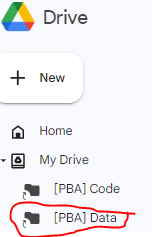

In [ ]:
# prompt: import util from https://github.com/The-Taimaka-Project/health-predictions.git brian-etl-code branch

!git clone -b brian-etl-code https://github.com/The-Taimaka-Project/health-predictions.git
#!git clone https://github.com/The-Taimaka-Project/health-predictions.git

# Change directory to the repository
%cd health-predictions/taimaka_health_predictions/inference
%pwd
from util import regress,find_collinear_columns,convert_to_bool,make_categorical,infer_phq_score
%cd /content


Cloning into 'health-predictions'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 179 (delta 31), reused 17 (delta 13), pack-reused 136 (from 1)
Receiving objects: 100% (179/179), 618.15 KiB | 5.62 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/health-predictions/packages/inference/run
/content


In [2]:
FAIL_MODE = True
TRAIN_MODE = True

In [18]:
import statsmodels.formula.api as smf
import pandas as pd
import pickle
import re
from tqdm import tqdm
import numpy as np
from warnings import simplefilter
import os
import logging



In [19]:
# prompt: use pthon logging library


# Create a logger
logger = logging.getLogger('my_logger')
logger.setLevel(logging.DEBUG) # Set the minimum logging level

# Create a handler to output logs to the console
console_handler = logging.StreamHandler()

file_handler = logging.FileHandler('my_log.log')
file_handler.setLevel(logging.INFO) # Set the logging level for the handler


# Create a formatter to specify the log message format
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(lineno)d - %(funcName)s - %(message)s')

# Add the formatter to the handler

file_handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(file_handler)



In [20]:
logger.debug("This is a debug message")
logger.info("This is an info message")
logger.warning("This is a warning message")
logger.error("This is an error message")
logger.critical("This is a critical message")

2025-06-08 20:16:20,733 - DEBUG - 1 - <cell line: 0> - This is a debug message
2025-06-08 20:16:20,734 - INFO - 2 - <cell line: 0> - This is an info message
2025-06-08 20:16:20,736 - WARNING - 3 - <cell line: 0> - This is a warning message
2025-06-08 20:16:20,737 - ERROR - 4 - <cell line: 0> - This is an error message
2025-06-08 20:16:20,738 - CRITICAL - 5 - <cell line: 0> - This is a critical message


In [5]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)


In [24]:
# prompt: read google shared drive file

from google.colab import drive
drive.mount('/content/drive')

dir = "/content/drive/My Drive/[PBA] Full datasets/"

current = pd.read_csv(dir+"FULL_pba_current_processed_2024-11-15.csv")
admit = pd.read_csv(dir+"FULL_pba_admit_processed_2024-11-15.csv")
weekly = pd.read_csv(dir+"FULL_pba_weekly_processed_2024-11-15.csv")
raw = pd.read_csv(dir+"FULL_pba_admit_raw_2024-11-15.csv")
weekly_raw = pd.read_csv(dir+"FULL_pba_weekly_raw_2024-11-15.csv")
itp = pd.read_csv(dir+"FULL_pba_itp_roster_2024-11-15.csv")
relapse = pd.read_csv(dir+"FULL_pba_relapse_raw2024-11-15.csv")
mh = pd.read_csv(dir+"FULL_pba_mh_raw2024-11-15.csv")


Mounted at /content/drive


<ipython-input-24-a79ae4cf4ab0>:9: DtypeWarning: Columns (7,9,13,15,17,20,33,47,53,54,55,56,57,58,85,86,102,104,105,135,137) have mixed types. Specify dtype option on import or set low_memory=False.
  admit = pd.read_csv(dir+"FULL_pba_admit_processed_2024-11-15.csv")
<ipython-input-24-a79ae4cf4ab0>:10: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  weekly = pd.read_csv(dir+"FULL_pba_weekly_processed_2024-11-15.csv")
<ipython-input-24-a79ae4cf4ab0>:11: DtypeWarning: Columns (6,9,10,11,12,13,20,22,23,24,25,30,34,35,36,51,54,56,60,65,71,72,73,74,82,86,88,89,92,93,94,95,96,98,99,101,102,103,105,116,127,140,157,158,175,176,190,191,192,193,194,195,196,197,198,199,204,206,214,217,219,228,230,231,232,237,240,241,242,245,247,253,260,266,275,276,277,278,279,280,287,288,289,290,291,292,293,294,295,296,297,331,357,371,380,407,409,413,418,420,421,428,440,445,450,452,469,470,477,484,532,537,542,543,659,660,661,665,666,667,668,669,700,719,720,72

In [ ]:
print(weekly_raw.shape,weekly_raw[['pid', 'todate', 'end_time']].isnull().sum(),weekly_raw[['pid', 'todate', 'end_time']].notnull().sum())
print('current',current.shape)
print('admit',admit.shape)
print('weekly',weekly.shape)
print('raw',raw.shape)
print('weekly',weekly_raw.shape)
print('itp',itp.shape)
print('relapse',relapse.shape)
print('mh',mh.shape)


(64152, 720) pid         0
todate      0
end_time    0
dtype: int64 pid         64152
todate      64152
end_time    64152
dtype: int64
current (10355, 20)
admit (10355, 147)
weekly (64288, 82)
raw (10416, 938)
weekly (64152, 720)
itp (4288, 15)
relapse (5591, 1272)
mh (4264, 739)


In [23]:
# prompt: use logger print(weekly_raw.shape,weekly_raw[['pid', 'todate', 'end_time']].isnull().sum(),weekly_raw[['pid', 'todate', 'end_time']].notnull().sum())
# print('current',current.shape)
# print('admit',admit.shape)
# print('weekly',weekly.shape)
# print('raw',raw.shape)
# print('weekly',weekly_raw.shape)
# print('itp',itp.shape)
# print('relapse',relapse.shape)
# print('mh',mh.shape)

logger.info(f"weekly_raw shape: {weekly_raw.shape}")
logger.info(f"weekly_raw null sums for pid, todate, end_time:\n{weekly_raw[['pid', 'todate', 'end_time']].isnull().sum()}")
logger.info(f"weekly_raw notnull sums for pid, todate, end_time:\n{weekly_raw[['pid', 'todate', 'end_time']].notnull().sum()}")
logger.info(f"current shape: {current.shape}")
logger.info(f"admit shape: {admit.shape}")
logger.info(f"weekly shape: {weekly.shape}")
logger.info(f"raw shape: {raw.shape}")
logger.info(f"weekly shape: {weekly_raw.shape}")
logger.info(f"itp shape: {itp.shape}")
logger.info(f"relapse shape: {relapse.shape}")
logger.info(f"mh shape: {mh.shape}")


2025-06-08 19:59:04,762 - INFO - weekly_raw shape: (64152, 720)
2025-06-08 19:59:04,762 - INFO - 11 - <cell line: 0> - weekly_raw shape: (64152, 720)
INFO:my_logger:weekly_raw shape: (64152, 720)
2025-06-08 19:59:04,783 - INFO - weekly_raw null sums for pid, todate, end_time:
pid         0
todate      0
end_time    0
dtype: int64
2025-06-08 19:59:04,783 - INFO - 12 - <cell line: 0> - weekly_raw null sums for pid, todate, end_time:
pid         0
todate      0
end_time    0
dtype: int64
INFO:my_logger:weekly_raw null sums for pid, todate, end_time:
pid         0
todate      0
end_time    0
dtype: int64
2025-06-08 19:59:04,803 - INFO - weekly_raw notnull sums for pid, todate, end_time:
pid         64152
todate      64152
end_time    64152
dtype: int64
2025-06-08 19:59:04,803 - INFO - 13 - <cell line: 0> - weekly_raw notnull sums for pid, todate, end_time:
pid         64152
todate      64152
end_time    64152
dtype: int64
INFO:my_logger:weekly_raw notnull sums for pid, todate, end_time:
pi

In [25]:
logger.info(weekly_raw[['pid', 'todate', 'end_time']].isnull().sum())

if weekly_raw[['pid', 'todate', 'end_time']].isnull().sum().sum() > 0 & FAIL_MODE:
  raise RuntimeError("primary must be populated:  null values found in weekly_raw[['pid', 'todate', 'end_time']].")

2025-06-08 20:23:11,289 - INFO - 1 - <cell line: 0> - pid         0
todate      0
end_time    0
dtype: int64


In [27]:
# Check for duplicate pids in the 'admit' DataFrame
duplicate_pids_admit = admit[admit.duplicated(subset=['pid'], keep=False)]

logger.info(f"Duplicate pids found in 'admit' DataFrame: {duplicate_pids_admit['pid'].unique()}")

# prompt: if not duplicate_pids_admit.empty throw a runtime exception

if (not duplicate_pids_admit.empty) & FAIL_MODE:
    raise RuntimeError("Duplicate pids found in 'admit' DataFrame.")


2025-06-08 20:24:37,112 - INFO - 1 - <cell line: 0> - Duplicate pids found in 'admit' DataFrame: []


# functions

In [28]:
# Identify columns with unique values [True, nan, False] and print null count
def find_3val_bool(df):
  for col in df.columns:
    if len(df[col].unique()) == 3:
        unique_vals = df[col].unique()
        if all(val in [True, False] or pd.isna(val) for val in unique_vals):
            null_ct = df[col].isnull().sum()
            size = df[col].size
            sum = df[col].sum()
            if null_ct > 0:
                logger.info(f"Found 3-val bool column '{col}' with null count: {null_ct} {null_ct/size*100:.1f}% sum:{sum}")
            else:
              logger.info(f"Found 3-val bool column '{col}' with null count: {df[col].isnull().sum()} sum:{sum}")
            #df[col] = df[col].fillna(False).astype(bool)
            #df[col] = df[col].astype(bool)

In [29]:
# prompt: convert detn columns with unique values [True nan False] to boolean

# Identify columns with unique values [True, nan, False] and convert them to boolean
def convert_3val_bool(df, threshold):
  for col in df.columns:
    if len(df[col].unique()) == 3:
        unique_vals = df[col].unique()
        if all(val in [True, False] or pd.isna(val) for val in unique_vals):
            null_ct = df[col].isnull().sum()
            if null_ct < threshold:
              logger.info(f"Converting 3-val bool column '{col}' with null count: {null_ct}")
              df[col] = df[col].fillna(False).astype(bool)

In [30]:
def convert_to_datetime(df):
  df_copy = df.copy()
  date_time_columns = []
  for col in df_copy.columns:
    if re.search(r'(date|time)', col, re.IGNORECASE):
      date_time_columns.append(col)
  for col in date_time_columns:
      df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
      df_copy[col].fillna(pd.NaT,inplace=True)
      df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce').dt.tz_localize(None)
      df_copy[col].fillna(pd.NaT,inplace=True)
      print(col, df_copy[col].dtypes)
  return df_copy

In [31]:
# prompt: rename admit finalhl column to hl

# Rename the 'admit_finalhl' column to 'hl' in the 'admit' DataFrame
admit.rename(columns={'finalhl': 'hl'}, inplace=True)
admit.drop(columns={'roundedhl'}, inplace=True)

In [32]:
admit['wfh'] = admit['weight']/admit['hl']
admit['hfa'] = admit['hl']/admit['age']
admit['wfa'] = admit['weight']/admit['age']

In [33]:
weekly['wfh'] = weekly['weight']/weekly['finalhl']
weekly['hfa'] = weekly['finalhl']/weekly['age']
weekly['wfa'] = weekly['weight']/weekly['age']

In [34]:
current = convert_to_datetime(current)
admit = convert_to_datetime(admit)
weekly = convert_to_datetime(weekly)
raw = convert_to_datetime(raw)
weekly_raw = convert_to_datetime(weekly_raw)
itp = convert_to_datetime(itp)
relapse = convert_to_datetime(relapse)
mh = convert_to_datetime(mh)


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

status_date datetime64[ns]
nvdate datetime64[ns]
calcdate datetime64[ns]
birthdate datetime64[ns]
md_submissiondate datetime64[ns]
md_starttime datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

md_endtime datetime64[ns]
manual_nvdate datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

calcdate datetime64[ns]
md_submissiondate datetime64[ns]
md_starttime datetime64[ns]
md_endtime datetime64[ns]
manual_nvdate datetime64[ns]


<ipython-input-30-6f0bb09a686b>:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplac

start_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplac

end_time datetime64[ns]
validdates datetime64[ns]
todate datetime64[ns]
birthdate datetime64[ns]
time_instruct datetime64[ns]
time_hours datetime64[ns]
time_minutes datetime64[ns]
fac_admitdate datetime64[ns]
fa1_date datetime64[ns]
pp_6wvax_dates datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
<ipython-input-30-6f0bb09a686b>:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will r

pp_10wvax_dates datetime64[ns]
pp_14wvax_dates datetime64[ns]
frc_dtime datetime64[ns]
frc_date datetime64[ns]
fa2_date datetime64[ns]
manual_nvdate datetime64[ns]
nv_date datetime64[ns]
instruct_nv_date datetime64[ns]
ferc_date datetime64[ns]
submission_date datetime64[ns]
updated_at datetime64[ns]


<ipython-input-30-6f0bb09a686b>:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplac

start_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplac

end_time datetime64[ns]
validdates datetime64[ns]
todate datetime64[ns]
ferc_date datetime64[ns]
manual_nvdate datetime64[ns]


<ipython-input-30-6f0bb09a686b>:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplac

nv_date datetime64[ns]
instruct_nv_date datetime64[ns]
f_date datetime64[ns]
frc_dtime datetime64[ns]
frc_date datetime64[ns]
fa2_date datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

submission_date datetime64[ns]
updated_at datetime64[ns]
admit_date datetime64[ns]
outcome_date datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

start_time datetime64[ns]
end_time datetime64[ns]
validdates datetime64[ns]
todate datetime64[ns]
ent_birthdate datetime64[ns]
pull_birthdate_otp datetime64[ns]
pull_birthdate_cc datetime64[ns]
pull_birthdate datetime64[ns]
birthdate datetime64[ns]
date datetime64[ns]
change_nvdate datetime64[ns]
start_time_assess datetime64[ns]
start_time_morbidities datetime64[ns]
start_time_malaria datetime64[ns]
start_time_phone datetime64[ns]
start_time_second_up datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

start_time_second datetime64[ns]
start_time_roster datetime64[ns]
start_time_whodas datetime64[ns]
start_time_phq9 datetime64[ns]
p0_end_time datetime64[ns]
p0_f_end_time datetime64[ns]
p1_end_time datetime64[ns]
p1_f_end_time datetime64[ns]
p2_end_time datetime64[ns]
p2_f_end_time datetime64[ns]
p3_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

p3_f_end_time datetime64[ns]
p4_end_time datetime64[ns]
p4_f_end_time datetime64[ns]
p5_end_time datetime64[ns]
p5_f_end_time datetime64[ns]
p6_end_time datetime64[ns]
p6_f_end_time datetime64[ns]
p7_end_time datetime64[ns]
p7_f_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

p8_end_time datetime64[ns]
p8_f_end_time datetime64[ns]
p9_end_time datetime64[ns]
p9_f_end_time datetime64[ns]
start_time_gad7 datetime64[ns]
start_time_iycf datetime64[ns]
time_to_breast datetime64[ns]
specify_other_time datetime64[ns]
start_time_diarrhea datetime64[ns]
start_time_water datetime64[ns]
start_time_sanitation datetime64[ns]
hand_washing_times datetime64[ns]
start_time_feed datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf62_end_time datetime64[ns]
cf62_f_end_time datetime64[ns]
cf1_end_time datetime64[ns]
cf1_f_end_time datetime64[ns]
cf2_end_time datetime64[ns]
cf2_f_end_time datetime64[ns]
cf3_end_time datetime64[ns]
cf3_f_end_time datetime64[ns]
cf4_end_time datetime64[ns]
cf4_f_end_time datetime64[ns]
cf5_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf5_f_end_time datetime64[ns]
cf6_end_time datetime64[ns]
cf6_f_end_time datetime64[ns]
cf7_end_time datetime64[ns]
cf7_f_end_time datetime64[ns]
cf8_end_time datetime64[ns]
cf8_f_end_time datetime64[ns]
cf9_end_time datetime64[ns]
cf9_f_end_time datetime64[ns]
cf10_end_time datetime64[ns]
cf10_f_end_time datetime64[ns]
cf11_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf11_f_end_time datetime64[ns]
cf12_end_time datetime64[ns]
cf12_f_end_time datetime64[ns]
cf13_end_time datetime64[ns]
cf13_f_end_time datetime64[ns]
cf14_end_time datetime64[ns]
cf14_f_end_time datetime64[ns]
cf15_end_time datetime64[ns]
cf15_f_end_time datetime64[ns]
cf16_end_time datetime64[ns]
cf16_f_end_time datetime64[ns]
cf17_end_time datetime64[ns]
cf17_f_end_time datetime64[ns]
cf18_end_time datetime64[ns]
cf18_f_end_time datetime64[ns]
cf19_end_time datetime64[ns]
cf19_f_end_time datetime64[ns]
cf20_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf20_f_end_time datetime64[ns]
cf21_end_time datetime64[ns]
cf21_f_end_time datetime64[ns]
cf22_end_time datetime64[ns]
cf22_f_end_time datetime64[ns]
cf23_end_time datetime64[ns]
cf23_f_end_time datetime64[ns]
cf24_end_time datetime64[ns]
cf24_f_end_time datetime64[ns]
cf25_end_time datetime64[ns]
cf25_f_end_time datetime64[ns]
cf26_end_time datetime64[ns]
cf26_f_end_time datetime64[ns]
cf27_end_time datetime64[ns]
cf27_f_end_time datetime64[ns]
cf28_end_time datetime64[ns]
cf28_f_end_time datetime64[ns]
cf29_end_time datetime64[ns]
cf29_f_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf30_end_time datetime64[ns]
cf30_f_end_time datetime64[ns]
cf31_end_time datetime64[ns]
cf31_f_end_time datetime64[ns]
cf32_end_time datetime64[ns]
cf32_f_end_time datetime64[ns]
cf33_end_time datetime64[ns]
cf33_f_end_time datetime64[ns]
cf34_end_time datetime64[ns]
cf34_f_end_time datetime64[ns]
cf35_end_time datetime64[ns]
cf35_f_end_time datetime64[ns]
cf36_end_time datetime64[ns]
cf36_f_end_time datetime64[ns]
cf37_end_time datetime64[ns]
cf37_f_end_time datetime64[ns]
cf38_end_time datetime64[ns]
cf38_f_end_time datetime64[ns]
cf39_end_time datetime64[ns]
cf39_f_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf40_end_time datetime64[ns]
cf40_f_end_time datetime64[ns]
cf41_end_time datetime64[ns]
cf41_f_end_time datetime64[ns]
cf42_end_time datetime64[ns]
cf42_f_end_time datetime64[ns]
cf43_end_time datetime64[ns]
cf43_f_end_time datetime64[ns]
cf44_end_time datetime64[ns]
cf44_f_end_time datetime64[ns]
cf45_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf45_f_end_time datetime64[ns]
cf46_end_time datetime64[ns]
cf46_f_end_time datetime64[ns]
cf47_end_time datetime64[ns]
cf47_f_end_time datetime64[ns]
cf48_end_time datetime64[ns]
cf48_f_end_time datetime64[ns]
cf49_end_time datetime64[ns]
cf49_f_end_time datetime64[ns]
cf50_end_time datetime64[ns]
cf50_f_end_time datetime64[ns]
cf51_end_time datetime64[ns]
cf51_f_end_time datetime64[ns]
cf52a_end_time datetime64[ns]
cf52a_f_end_time datetime64[ns]
cf53a_end_time datetime64[ns]
cf53a_f_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf52_end_time datetime64[ns]
cf52_f_end_time datetime64[ns]
cf53_end_time datetime64[ns]
cf53_f_end_time datetime64[ns]
cf54_end_time datetime64[ns]
cf54_f_end_time datetime64[ns]
cf55_end_time datetime64[ns]
cf55_f_end_time datetime64[ns]
cf56_end_time datetime64[ns]
cf56_f_end_time datetime64[ns]
cf57_end_time datetime64[ns]
cf57_f_end_time datetime64[ns]
cf58_end_time datetime64[ns]
cf58_f_end_time datetime64[ns]
cf59_end_time datetime64[ns]
cf59_f_end_time datetime64[ns]
cf60_end_time datetime64[ns]
cf60_f_end_time datetime64[ns]
cf63_end_time datetime64[ns]
cf63_f_end_time datetime64[ns]
cf64_end_time datetime64[ns]
cf64_f_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf65_end_time datetime64[ns]
cf65_f_end_time datetime64[ns]
cf61_end_time datetime64[ns]
cf61_f_end_time datetime64[ns]
start_time_under5 datetime64[ns]
time_depressed datetime64[ns]
time_kick datetime64[ns]
start_time_discipline datetime64[ns]
start_time_function datetime64[ns]
start_time_vaccination datetime64[ns]
start_time_vaccination_c datetime64[ns]
start_time_roster_c datetime64[ns]
start_time_death datetime64[ns]
start_time_death_under5 datetime64[ns]
start_time_iycf_k datetime64[ns]
start_time_iycf_c datetime64[ns]
start_time_decision datetime64[ns]
start_time_mobility datetime64[ns]
start_time_capa datetime64[ns]
mc_time_note datetime64[ns]
mc_time_fin datetime64[ns]
mc_time_work datetime64[ns]
mc_time_stress datetime64[ns]
mc_time_worry datetime64[ns]
mc_time_sleep datetime64[ns]
mc_time_care datetime64[ns]
start_time_use datetime64[ns]
start_time_time datetime64[ns]
activity_end_time_0 datetime64[ns]
formatted_end_time_0 datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

last_end_time datetime64[ns]
start_time_wdds datetime64[ns]
start_time_cfq datetime64[ns]
start_time_panas datetime64[ns]
start_time_behavior datetime64[ns]
start_time_assets datetime64[ns]
start_time_ppi datetime64[ns]
start_time_hfias datetime64[ns]
start_time_assist datetime64[ns]
start_time_pm datetime64[ns]
start_time_shock datetime64[ns]
start_time_dv datetime64[ns]
start_time_dv_a datetime64[ns]
start_time_next datetime64[ns]
nv_date datetime64[ns]
start_time_incentives datetime64[ns]
submission_date datetime64[ns]
updated_at datetime64[ns]
start_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

end_time datetime64[ns]
validdates datetime64[ns]
todate datetime64[ns]
date_consult datetime64[ns]
p0_end_time datetime64[ns]
p0_f_end_time datetime64[ns]
p1_end_time datetime64[ns]
p1_f_end_time datetime64[ns]
p2_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

p2_f_end_time datetime64[ns]
p3_end_time datetime64[ns]
p3_f_end_time datetime64[ns]
p4_end_time datetime64[ns]
p4_f_end_time datetime64[ns]
p5_end_time datetime64[ns]
p5_f_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

p6_end_time datetime64[ns]
p6_f_end_time datetime64[ns]
p7_end_time datetime64[ns]
p7_f_end_time datetime64[ns]
p8_end_time datetime64[ns]
p8_f_end_time datetime64[ns]
p9_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

p9_f_end_time datetime64[ns]
date datetime64[ns]
cf0_end_time datetime64[ns]
cf0_f_end_time datetime64[ns]
cf1_end_time datetime64[ns]
cf1_f_end_time datetime64[ns]
cf2_end_time datetime64[ns]
cf2_f_end_time datetime64[ns]
cf3_end_time datetime64[ns]
cf3_f_end_time datetime64[ns]
cf4_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf4_f_end_time datetime64[ns]
cf5_end_time datetime64[ns]
cf5_f_end_time datetime64[ns]
cf6_end_time datetime64[ns]
cf6_f_end_time datetime64[ns]
cf7_end_time datetime64[ns]
cf7_f_end_time datetime64[ns]
cf8_end_time datetime64[ns]
cf8_f_end_time datetime64[ns]
cf9_end_time datetime64[ns]
cf9_f_end_time datetime64[ns]
cf10_end_time datetime64[ns]
cf10_f_end_time datetime64[ns]
cf11_end_time datetime64[ns]
cf11_f_end_time datetime64[ns]
cf12_end_time datetime64[ns]
cf12_f_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf13_end_time datetime64[ns]
cf13_f_end_time datetime64[ns]
cf14_end_time datetime64[ns]
cf14_f_end_time datetime64[ns]
cf15_end_time datetime64[ns]
cf15_f_end_time datetime64[ns]
cf16_end_time datetime64[ns]
cf16_f_end_time datetime64[ns]
cf17_end_time datetime64[ns]
cf17_f_end_time datetime64[ns]
cf18_end_time datetime64[ns]
cf18_f_end_time datetime64[ns]
cf19_end_time datetime64[ns]
cf19_f_end_time datetime64[ns]
cf20_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf20_f_end_time datetime64[ns]
cf21_end_time datetime64[ns]
cf21_f_end_time datetime64[ns]
cf22_end_time datetime64[ns]
cf22_f_end_time datetime64[ns]
cf23_end_time datetime64[ns]
cf23_f_end_time datetime64[ns]
cf24_end_time datetime64[ns]
cf24_f_end_time datetime64[ns]
cf25_end_time datetime64[ns]
cf25_f_end_time datetime64[ns]
cf26_end_time datetime64[ns]
cf26_f_end_time datetime64[ns]
cf27_end_time datetime64[ns]
cf27_f_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf28_end_time datetime64[ns]
cf28_f_end_time datetime64[ns]
cf29_end_time datetime64[ns]
cf29_f_end_time datetime64[ns]
cf30_end_time datetime64[ns]
cf30_f_end_time datetime64[ns]
cf31_end_time datetime64[ns]
cf31_f_end_time datetime64[ns]
cf32_end_time datetime64[ns]
cf32_f_end_time datetime64[ns]
cf33_end_time datetime64[ns]
cf33_f_end_time datetime64[ns]
cf34_end_time datetime64[ns]
cf34_f_end_time datetime64[ns]
cf35_end_time datetime64[ns]
cf35_f_end_time datetime64[ns]
cf36_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf36_f_end_time datetime64[ns]
cf37_end_time datetime64[ns]
cf37_f_end_time datetime64[ns]
cf38_end_time datetime64[ns]
cf38_f_end_time datetime64[ns]
cf39_end_time datetime64[ns]
cf39_f_end_time datetime64[ns]
cf40_end_time datetime64[ns]
cf40_f_end_time datetime64[ns]
cf41_end_time datetime64[ns]
cf41_f_end_time datetime64[ns]
cf42_end_time datetime64[ns]
cf42_f_end_time datetime64[ns]
cf43_end_time datetime64[ns]
cf43_f_end_time datetime64[ns]
cf44_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf44_f_end_time datetime64[ns]
cf45_end_time datetime64[ns]
cf45_f_end_time datetime64[ns]
cf46_end_time datetime64[ns]
cf46_f_end_time datetime64[ns]
cf47_end_time datetime64[ns]
cf47_f_end_time datetime64[ns]
cf48_end_time datetime64[ns]
cf48_f_end_time datetime64[ns]
cf49_end_time datetime64[ns]
cf49_f_end_time datetime64[ns]
cf50_end_time datetime64[ns]
cf50_f_end_time datetime64[ns]
cf51_end_time datetime64[ns]
cf51_f_end_time datetime64[ns]
cf52a_end_time datetime64[ns]
cf52a_f_end_time datetime64[ns]


<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

cf53a_end_time datetime64[ns]
cf53a_f_end_time datetime64[ns]
cf52_end_time datetime64[ns]
cf52_f_end_time datetime64[ns]
cf53_end_time datetime64[ns]
cf53_f_end_time datetime64[ns]
cf54_end_time datetime64[ns]
cf54_f_end_time datetime64[ns]
cf55_end_time datetime64[ns]
cf55_f_end_time datetime64[ns]
cf56_end_time datetime64[ns]
cf56_f_end_time datetime64[ns]
cf57_end_time datetime64[ns]
cf57_f_end_time datetime64[ns]
cf58_end_time datetime64[ns]
cf58_f_end_time datetime64[ns]
cf59_end_time datetime64[ns]
cf59_f_end_time datetime64[ns]
cf60_end_time datetime64[ns]
cf60_f_end_time datetime64[ns]
cf62_end_time datetime64[ns]
cf62_f_end_time datetime64[ns]
cf63_end_time datetime64[ns]
cf63_f_end_time datetime64[ns]
cf64_end_time datetime64[ns]
cf64_f_end_time datetime64[ns]
cf65_end_time datetime64[ns]
cf65_f_end_time datetime64[ns]
cf61_end_time datetime64[ns]
cf61_f_end_time datetime64[ns]
intruct_date datetime64[ns]
submission_date datetime64[ns]
updated_at datetime64[ns]


<ipython-input-30-6f0bb09a686b>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(pd.NaT,inplace=True)
<ipython-input-30-6f0bb09a686b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

drop the 5 (out of 2000) that are duplicated on admit_date and outcome_date within pid.  The differences in 'muac', 'age', 'initial_dx' are immaterial and insignificant

# ITP Roster

ITP (itp_roster) dataset can supplement the hospital referral data from the Admit and Weekly datasets.
Has details on length of stay in the ITP (hospital), whether the death occurred in the ITP, and diagnosis in the ITP.
Captures self-referrals (i.e., patients who present at ITP without going to OTP first - relatively rare, but does happen occasionally)


In [35]:
# prompt: sort itp by muac,age,initial_dx and deduplicate on pid,admit_date,outcome_date

# Sort by muac, age, initial_dx and then deduplicate on pid, admit_date, outcome_date so the record selection is determinative
itp_sorted = itp.sort_values(['muac', 'age', 'initial_dx'])
itp_deduped = itp_sorted.drop_duplicates(subset=['pid', 'admit_date', 'outcome_date'], keep='first')
logger.info(itp_sorted.shape)
logger.info(itp_deduped.shape)


2025-06-08 20:30:19,678 - INFO - 6 - <cell line: 0> - (4288, 15)
2025-06-08 20:30:19,681 - INFO - 7 - <cell line: 0> - (4281, 15)


In [36]:
if (itp_sorted.shape[0] != itp_deduped.shape[0]) & FAIL_MODE:
  raise RuntimeError(f"itp has {itp_sorted.shape[0] - itp_deduped.shape[0]} duplicate rows for ['pid', 'admit_date', 'outcome_date'].")

RuntimeError: itp has 7 duplicate rows for ['pid', 'admit_date', 'outcome_date'].

about 434 have null los_days but have both admit_date and outcome_date so go ahead and populate los_days which also fixes the 2 los_days that incorrectly calculated the difference

In [37]:
itp_deduped['admit_date'] = pd.to_datetime(itp_deduped['admit_date'])
itp_deduped['outcome_date'] = pd.to_datetime(itp_deduped['outcome_date'],format='mixed')
# 434 itp.los_days rows are null so populate them and fix the 2 wrong ones
itp_deduped['los_days'] = (itp_deduped['outcome_date'] - itp_deduped['admit_date']).dt.days

<ipython-input-37-5bdb56344c0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itp_deduped['admit_date'] = pd.to_datetime(itp_deduped['admit_date'])
<ipython-input-37-5bdb56344c0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itp_deduped['outcome_date'] = pd.to_datetime(itp_deduped['outcome_date'],format='mixed')
<ipython-input-37-5bdb56344c0c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

calculate useful aggregate stats for itp roster

In [38]:
# sort the most recent itp_roster row first so when flattened, occurrence 1 will be row 1
itp_deduped = itp_deduped.sort_values(['pid', 'admit_date','outcome_date'],ascending=False)

In [40]:
# prompt: for itp_deduped['outcome'] == 'Death' are there duplicate pid?

# Filter for rows where outcome is 'Death'
death_cases = itp_deduped[itp_deduped['outcome'] == 'Death']

# Check for duplicate pids in the filtered dataset
duplicate_pids = death_cases[death_cases.duplicated(subset=['pid'], keep=False)]

# Print the duplicate pids if any are found
if not duplicate_pids.empty:
  logger.error("Duplicate pids found for outcome 'Death':")
  logger.error(duplicate_pids['pid'].unique())
  if FAIL_MODE:
    raise RuntimeError("Duplicate itp pids found for outcome 'Death'.")
else:
  logger.info("No duplicate pids found for outcome 'Death'.")


2025-06-08 20:32:40,229 - INFO - 16 - <cell line: 0> - No duplicate pids found for outcome 'Death'.


In [41]:
# prompt: deduplicate death_cases on pid using the highest admit_date, just to be safe

# Group by 'pid' and select the row with the highest 'admit_date' for each group
death_cases = death_cases.loc[death_cases.groupby('pid')['admit_date'].idxmax()]

# Now, 'death_cases' contains only unique 'pid's with the highest 'admit_date'

In [42]:
# prompt: group itp by pid and create a dataframe with row_count,min(weight),max(weight),average(weight),min(muac),max(muac),average(muac) per pid

itp_agg = itp_deduped.groupby('pid').agg(
    itp_row_count=('pid', 'count'),
    itp_first_admit=('admit_date', 'last'),
    itp_last_admit=('admit_date', 'first'),
    itp_avg_los_days=('los_days', 'mean'),
    itp_min_los_days=('los_days', 'min'),
    itp_max_los_days=('los_days', 'max'),
    itp_last_muac=('muac', 'first'),
    itp_first_muac=('muac', 'last'),
    itp_min_muac=('muac', 'min'),
    itp_max_muac=('muac', 'max'),
    itp_avg_muac=('muac', 'mean'),
    itp_avg_age=('age', 'mean')
)

itp_agg.reset_index(inplace=True)

We can't join itp_roster to weekly so just flatten the rows to columns per itp_roster entry so itp1, itp2 and itp3 prefixed columns.
Since only 6 pids have more than 3 roster entries, just use the first 3 to avoid unnecessary columns with mainly nulls anyway.

In [43]:
# prompt: select rows in each group itp_deduped.groupby('pid')['pid'] where cumcount() < 3


# Group by 'pid' and select the first 3 rows within each group
selected_rows = itp_deduped.groupby('pid').apply(lambda x: x.head(3))

selected_rows.drop('pid',inplace=True,axis=1)
selected_rows.reset_index(inplace=True)

itp_series = (selected_rows.assign(col=selected_rows.groupby('pid').cumcount()+1)
   .set_index(['pid','col'])
   .unstack('col')
   .sort_index(level=(1,0), axis=1)
)
itp_series.columns = [f"itp{y}_{x}" for x,y in itp_series.columns]
# prompt: make itp_series.index a column named 'pid'


itp_series = itp_series.reset_index()
#print(itp_series.shape)
#print(itp_series.columns)
#print(print(itp_series[itp_series['pid'] == '23-0212'][['itp1_admit_date','itp2_admit_date','itp3_admit_date']]))

<ipython-input-43-0f15722f11d3>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_rows = itp_deduped.groupby('pid').apply(lambda x: x.head(3))


# Admit Raw

In [ ]:
# prompt: drop status column from raw
# as it's all nulls and gets confused with current.status

logger.debug(f"raw shape: {raw.shape}")
raw = raw.drop('status', axis=1)
raw.drop('glbsite',axis=1,inplace=True)
logger.debug(f"raw shape: {raw.shape}")

raw (10416, 938)
raw (10416, 936)


In [44]:
# prompt: log ('raw',raw.shape)

logger.info(f"raw shape: {raw.shape}")

2025-06-08 20:35:39,796 - INFO - 3 - <cell line: 0> - raw shape: (10416, 938)


In [45]:
for col in [col for col in raw.columns if 'threshold' in col]:
  raw[col] = pd.to_numeric(raw[col], errors='coerce')

In [46]:
# prompt: find raw['id'] that contain 'uuid:'

uuids_in_raw = raw[raw['id'].str.contains('uuid:', na=False)]

# prompt: throw runtime if uuids_in_raw not empty
if (not uuids_in_raw.empty) & FAIL_MODE:
    raise RuntimeError("raw['id'] contains the string 'uuid'.")

# prompt: rename raw['id'] to raw['uuid']

raw = raw.rename(columns={'id': 'uuid'})

Raw (pulled from ODK Central - contains ALL variables): https://drive.google.com/file/d/1pYenMl3EiSjD48N_lq2zZ2quBa4QGOVT/view?usp=drive_link

In [47]:
# drop columns in raw that are the same name (and value) in admit
# their values are the same so no need for confusion and the need to disambiguate between admit and raw
# simplifies and clarifies

cols_to_drop = ['site',
 'site_type',
 'staffmember',
 'receiving_otp',
 'state',
 'other_state',
 'gombe_lga',
 'other_lga',
 'settlement',
 'b_prevenr',
 'prev_pid',
 'b_knowsbday',
 'birthdate',
 'weight',
 'muac',
 'c_oedema',
 'b_twinalive',
 'b_cgishoh',
 'cg_sex',
 'cg_age',
 'c_vcardloc',
 'manual_nvdate',
 'cleaning_note',
 'b_has_phone_number']

raw = raw.drop([col for col in cols_to_drop if col in raw.columns], axis=1)


logger.debug(f"raw shape: {raw.shape}")



2025-06-08 20:37:45,079 - DEBUG - 33 - <cell line: 0> - raw shape: (10416, 914)


In [49]:
# prompt: find duplicated pid in admit_raw

# Find duplicate pids in admit_raw
duplicated_pids_raw = raw[raw.duplicated(subset=['pid'], keep=False)]['pid'].unique()
logger.warn(f"duplicated_pids_raw: {duplicated_pids_raw.size} {duplicated_pids_raw}")
if (duplicated_pids_raw.size > 0) & FAIL_MODE:
    raise RuntimeError(f'{duplicated_pids_raw.size} duplicate pids found in admit_raw.')

<ipython-input-49-036a4b77a66d>:5: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(f"duplicated_pids_raw: {duplicated_pids_raw.size} {duplicated_pids_raw}")
2025-06-08 20:40:26,328 - WARNING - 5 - <cell line: 0> - duplicated_pids_raw: 82 ['25-2686' '25-2379' '25-2548' '25-2568' '25-2142' '25-2489' '25-2378'
 '25-1661' '24-4831' '24-2753' '24-2765' '24-4147' '24-4137' '24-2761'
 '24-2763' '24-2830' '24-2894' '24-1607' '24-2756' '24-2757' '24-2752'
 '24-2751' '24-1944' '24-1957' '24-2128' '24-1956' '24-1950' '24-1958'
 '24-1954' '24-1606' '24-1758' '24-1937' '24-1938' '24-1942' '24-1935'
 '24-1524' '24-1518' '24-1415' '24-1427' '24-1227' '24-0981' '24-1063'
 '24-1228' '24-0980' '24-0860' '24-0861' '24-0859' '24-0858' '24-0853'
 '24-0865' '24-0854' '24-0851' '24-0453' '24-0366' '23-1419' '23-3088'
 '23-0872' '23-0871' '23-3160' '23-1420' '23-0870' '23-1404' '23-0435'
 '23-0429' '23-0428' '23-0431' '23-0295' '23-0868' '23-0545' '23-0390'
 '23-0286' 

RuntimeError: 82 duplicate pids found in admit_raw.

In [50]:
# prompt: deduplicate raw on pid,todate using the first row
# first row of group is latest start_time, most recent for a todate
raw = raw.sort_values(['pid', 'todate','start_time'],ascending=[True,False,False])
# diarrhea null rate is 0.091659 for todate descending and ascending so use descending to get the most recent
logger.debug(f"raw shape: {raw.shape}")
# Group by pid and, then take the first row (latest todate, start_time) within each group
raw = raw.groupby(['pid'], as_index=False).first()
logger.debug(f"raw shape: {raw.shape}")


2025-06-08 20:42:34,535 - DEBUG - 5 - <cell line: 0> - raw shape: (10416, 914)
<ipython-input-50-639dd2ac3b9c>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  raw = raw.groupby(['pid'], as_index=False).first()
2025-06-08 20:42:35,785 - DEBUG - 8 - <cell line: 0> - raw shape: (10334, 914)


In [ ]:
# prompt: raw['emergency_admission']=1 if pid in duplicated_pids_raw

raw['emergency_admission'] = raw['pid'].isin(duplicated_pids_raw).astype(int)

In [52]:
# prompt: find duplicate raw['id']

duplicate_raw_ids = raw[raw.duplicated(subset=['uuid'], keep=False)]
logger.debug(f"duplicated_pids_raw: {duplicate_raw_ids.size} {duplicate_raw_ids}")


# prompt: if duplicate_raw_ids not empty raise runtime exception

if (not duplicate_raw_ids.empty) & FAIL_MODE:
    raise RuntimeError(f"{duplicate_raw_ids.size} duplicate raw['id'] found for a pid.")


<ipython-input-52-e238a4c6f10a>:4: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(f"duplicated_pids_raw: {duplicate_raw_ids.size} {duplicate_raw_ids}")
2025-06-08 20:44:25,759 - WARNING - 4 - <cell line: 0> - duplicated_pids_raw: 0 Empty DataFrame
Columns: [pid, start_time, end_time, deviceid, glbsite, validdates, todate, data_expired, warn_exp_data, disp_yno_def_9, b_dpth_sorethroat, b_dpth_diffswallow, b_dpth_bloody, b_dpth_lymph, b_suspecteddipth, instruct_suspectedipth, havedipthinstruct, validotps, validitps, precalc_itpotp, manual_itpotp, manual_otp, manual_itp, precalcsite, otps_with_outreaches, b_outreach, c_which_outreach, staff_filter, ofstaffmember, final_staffmember, otherstaff, imci_emergency_list, spec_imci_em_other, imci_emergency_otp, exit_imciemergency, imci_emergency_itp, disp_yno_def_40, b_cpalate, b_hydrocephalus, b_prolap_hernia, b_downsynd, b_sicklecell, b_def_oth, b_fract_traum, def_pres, exit_fract_traum, exit_def_pres, 

In [ ]:
# prompt: are there any columns in raw that have only 1 nunique()?
# if so, drop them as they add no value, eliminates 80 columns

cols_with_one_nunique = [col for col in raw.columns if raw[col].nunique() == 1]
logger.debug(f"Number of columns with one unique value: {len(cols_with_one_nunique)}")
logger.debug(f"Columns with one unique value: {cols_with_one_nunique}")


# then drop them
logger.debug(f"raw shape: {raw.shape}")
raw.drop(cols_with_one_nunique, axis=1, inplace=True)
logger.debug(f"raw shape: {raw.shape}")


75 ['validdates', 'data_expired', 'b_dpth_sorethroat', 'b_dpth_diffswallow', 'b_dpth_bloody', 'b_dpth_lymph', 'b_suspecteddipth', 'validitps', 'otps_with_outreaches', 'c_which_outreach', 'b_cpalate', 'b_hydrocephalus', 'b_prolap_hernia', 'b_downsynd', 'b_sicklecell', 'b_def_oth', 'b_fract_traum', 'def_pres', 'b_figurepid', 'b_correct_prevpid', 'c_azafu_symptoms', 'b_azafu_multivomitepi', 'b_azafu_vomitl24', 'c_azafu_vomitl24freq', 'b_azafu_vomiteveryoral', 'b_azafu_soughtcare', 'c_azafu_whycare', 'b_azafu_overnightcare', 'c_azafu_whyovernightcare', 'c_azafu_urinefreq', 'c_azafu_urinecolor', 'b_azafu_otherprob', 'b_azafu_reqclinician', 'proceed_previnel', 'b_too_old', 'weightconfirm', 'indiv_valid_admit', 'mam_needsitp', 'earlyref_text', 'q_conf_override_eref', 'q_cgaccept_eref', 'cgrefused_eref', 'manual_admit_type_other', 'b_usedpid', 'phone_consent', 'nophone_consent', 'wall_type_other', 'drinking_water_other', 'resp_rate_3', 'resp3_elev', 'b_corncloud', 'b_cornulc', 'q_conf_override

# Weekly Raw

Raw (pulled from ODK Central - contains ALL variables): https://drive.google.com/file/d/1SA0Njnc2jhEDz_tZoAKwcGpnvBe32jJS/view?usp=drive_link
The following variables have been removed to limit the amount of PII shared: -phone, -pull_homedesc, -pull_cg_name, -pull_phone
In place of phone number (phone), b_added_phone_number has been added; if the PID added or changed a phone number at that visit, b_added_phone_number = TRUE
Variable names correspond to the ‘name’ column of the ODK form (linked above)


In [53]:
# Replace 'resp_rate' values greater than 300 with 'resp_rate_2' values
weekly_raw.loc[weekly_raw['resp_rate'] > 300, 'resp_rate'] = weekly_raw['resp_rate_2']
weekly_raw.drop(columns=['resp_rate_2'], inplace=True)
weekly_raw.drop(columns=['resp_rate_3'], inplace=True)

In [54]:
# drop columns in weekly_raw that are the same in weekly
weekly_raw = weekly_raw.drop(['site_type',
'manual_nvdate',
'b_added_phone_number',
'b_excluded'],axis = 1)

# only 3 muac rows values differ and only 2 weight row values differ between weekly_raw and weekly so they can be dropped too
weekly_raw = weekly_raw.drop(['muac','weight'],axis = 1)
logger.debug(f"weekly_raw shape: {weekly_raw.shape}")

2025-06-08 20:50:21,712 - DEBUG - 1 - <cell line: 0> - weekly_raw shape: (64152, 718)


In [55]:
# prompt: find the 304 columns in weekly_raw that are all nulls and drop them

null_cols = weekly_raw.columns[weekly_raw.isnull().all()].tolist()
logger.debug(f"Number of null columns in weekly_raw: {len(null_cols)}")
logger.debug(f"Null columns in weekly_raw: {null_cols}")
logger.debug(f"weekly_raw shape before dropping null columns: {weekly_raw.shape}")
weekly_raw.drop(null_cols, axis=1, inplace=True)
logger.debug(f"weekly_raw shape after dropping null columns: {weekly_raw.shape}")

2025-06-08 20:52:38,201 - DEBUG - 4 - <cell line: 0> - Number of null columns in weekly_raw: 306
2025-06-08 20:52:38,209 - DEBUG - 5 - <cell line: 0> - Null columns in weekly_raw: ['warn_exp_data', 'disp_yno_def', 'instruct_suspectedipth', 'havedipthinstruct', 'error_tpidmm', 'error_invalidpid', 'error_unusedpid', 'instruct_verifypid', 'vp_name', 'vp_age', 'vp_sex', 'vp_enr_malnstat', 'vp_cg_name', 'vp_settlement', 'error_pidmm', 'manual_itp', 'error_itpfilling', 'exit_imciemergency', 'emref_instruct', 'ferc_itp', 'ferc_date', 'ferc_cg_name', 'ferc_phone', 'ferc_name', 'ferc_pid', 'ferc_settlement', 'ferc_sex', 'ferc_age', 'ferc_reason', 'emref_instruct_trans', 'instruct_callclinicalauth', 'exit_excluded', 'error_wrongform', 'prev_hasphone', 'prev_nophone', 'nonconsent_reason', 'instruct_ses', 'instruct_seshonest', 'instruct_householddef', 'wall_type_other', 'toilet_other', 'inac_weight_measurement', 'warn_invalidweight', 'disp_weight', 'warn_wrongweight', 'info_needlength', 'length_me

In [ ]:
# prompt: conver print(len(null_cols),null_cols)
# print('weekly_raw',weekly_raw.shape) to logger

logger.info(f"Number of null columns in weekly_raw: {len(null_cols)}")
logger.info(f"Null columns in weekly_raw: {null_cols}")
logger.info(f"weekly_raw shape before dropping null columns: {weekly_raw.shape}")
weekly_raw.drop(null_cols, axis=1, inplace=True)
logger.info(f"weekly_raw shape after dropping null columns: {weekly_raw.shape}")

In [56]:
# prompt: are there any columns in relapse that have only 1 nunique()?
# if so, drop them as they add no value, eliminates 45 columns

cols_with_one_nunique = [col for col in weekly_raw.columns if weekly_raw[col].nunique() == 1]
logger.debug(f"{len(cols_with_one_nunique)} {cols_with_one_nunique}")


# then drop them
logger.debug(f"weekly_raw shape: {weekly_raw.shape}")
weekly_raw.drop(cols_with_one_nunique, axis=1, inplace=True)
logger.debug(f"weekly_raw shape: {weekly_raw.shape}")


2025-06-08 20:55:16,740 - DEBUG - 5 - <cell line: 0> - 40 ['validdates', 'data_expired', 'b_dpth_sorethroat', 'b_dpth_diffswallow', 'b_dpth_bloody', 'b_dpth_lymph', 'b_suspecteddipth', 'b_unusedpid', 'pull_supervisor_itp_referral', 'cat1_supervisorreferral', 'b_crpid', 'validitps', 'manual_itpotp', 'otps_with_outreaches', 'c_which_outreach', 'site_type', 'phone_owner_samecomm', 'phone_consent', 'otherlang_text', 'drinking_water_other', 'weightconfirm', 'eref_tsref', 'q_conf_override_eref', 'q_cgaccept_eref', 'cgrefused_eref', 'resp3_elev', 'disp_yno_breath', 'b_bitot', 'b_corncloud', 'override_conf', 'expl_addtetra', 'expl_addzincox', 'manual_dose_aa_act1', 'cat1_needsinjectableaa', 'conf_changedose', 'discharge_override_conf', 'dischargenr_override_conf', 'pull_authoutreaches', 'review_state', 'odata_context']
2025-06-08 20:55:16,747 - DEBUG - 9 - <cell line: 0> - weekly_raw shape: (64152, 412)
2025-06-08 20:55:17,089 - DEBUG - 11 - <cell line: 0> - weekly_raw shape: (64152, 372)


## impute missing cat1/cat2 in admit raw from the first weekly raw cat1/cat2

looking at the 692 admit raw missing cat1/cat2, 685 had one or more of these flags set:
 b_referred_emergency      13
b_presented_emergency    110
b_needsitp               594
the mean number of days between admittance (admit processed calcdate) and first visit date is 12 days with 75% 2 weeks or under.  I think it's safe to impute the first visit's cat1/cat2 values to the missing admit_raw cat1/cat2 values.  This will make modelling easier and more accurate and reduce the number nulls from 9.2% to 1.6%, an 82% reduction.

In [57]:
# prompt: find all cat2 and cat2 prefixed columns in raw (weekly_raw has the same, too.)
cat1_cols_raw = [col for col in raw.columns if col.startswith('cat1')]
cat2_cols_raw = [col for col in raw.columns if col.startswith('cat2')]
cat_1_2_cols  = cat1_cols_raw + cat2_cols_raw


In [58]:
cat1_cols_raw_weekly = [col for col in weekly_raw.columns if col.startswith('cat1')]
cat2_cols_raw_weekly = [col for col in weekly_raw.columns if col.startswith('cat2')]
cat_1_2_cols_weekly  = cat1_cols_raw_weekly + cat2_cols_raw_weekly

In [60]:
# prompt: find cat_1_2_cols_weekly not in cat_1_2_cols

# Find columns in cat_1_2_cols_weekly that are NOT in cat_1_2_cols
cols_not_in_admit = set(cat_1_2_cols_weekly) - set(cat_1_2_cols)

logger.debug(f"Columns in 'cat_1_2_cols_weekly' but not in 'cat_1_2_cols': {cols_not_in_admit}")

2025-06-08 20:56:17,593 - DEBUG - 6 - <cell line: 0> - Columns in 'cat_1_2_cols_weekly' but not in 'cat_1_2_cols': {'cat1_unresolvedmalaria'}


In [61]:
# prompt: find cat_1_2_cols not in cat_1_2_cols_weekly

# Find columns in cat_1_2_cols that are NOT in cat_1_2_cols_weekly
cols_not_in_weekly = set(cat_1_2_cols) - set(cat_1_2_cols_weekly)

logger.debug(f"Columns in 'cat_1_2_cols' but not in 'cat_1_2_cols_weekly': {cols_not_in_weekly}")

2025-06-08 20:56:20,987 - DEBUG - 6 - <cell line: 0> - Columns in 'cat_1_2_cols' but not in 'cat_1_2_cols_weekly': set()


In [64]:
# prompt: get row with first todate by pid for weekly_raw

# Assuming weekly_raw is already sorted by pid and todate as in the provided code.

# Get the first todate for each pid
first_todate_by_pid = weekly_raw.groupby('pid')['todate'].first()

# To get the entire row corresponding to the first todate for each pid, you can use the following:
# prompt: do rows_with_first_todate = weekly_raw[weekly_raw.apply(lambda row: (row['pid'], row['todate']) in first_todate_by_pid.items(), axis=1)] faster
# make this run faster than 21 minutes

# To get the entire row corresponding to the first todate for each pid, you can use the following:
# This is significantly faster than using .apply with a lambda function iterating over rows.
# We can achieve the same result by merging the weekly_raw with the first_todate_by_pid series.

rows_with_first_todate = pd.merge(
    weekly_raw,
    first_todate_by_pid.reset_index(),
    on=['pid', 'todate']
)


In [65]:
# prompt: what columns are in both cat_1_2_cols and cat_1_2_cols_weekly

# Find the common columns
cat_1_2_cols = list(set(cat_1_2_cols) & set(cat_1_2_cols_weekly))


In [66]:
# prompt: join raw to first_todate_by_pid on pid,todate

# Merge raw with first_todate_by_pid on pid and todate
raw_first_weekly = pd.merge(raw, rows_with_first_todate[cat_1_2_cols + ['pid']], on=['pid'], how='left', suffixes=('', '_first_todate'))

In [67]:
# prompt: append '_first_todate' to each element in diarrhea_cols

cat_1_2_cols_updated = [col + '_first_todate' for col in cat_1_2_cols]

In [68]:
# prompt: for each col in diarrhea_cols raw_first_weekly fillna with col+'_first_todate'

logger.debug(f'raw {raw.shape}')
for col in cat_1_2_cols:
    raw_first_weekly[col] = raw_first_weekly[col].fillna(raw_first_weekly[col + '_first_todate'])

raw= raw_first_weekly.drop(columns=cat_1_2_cols_updated)
logger.debug(f'raw {raw.shape}')

2025-06-08 20:58:55,049 - DEBUG - 3 - <cell line: 0> - raw (10334, 914)
2025-06-08 20:58:55,152 - DEBUG - 8 - <cell line: 0> - raw (10339, 914)


# Admit Processed

Admit - individual patient records, organized by patient ID number, for approximately 7,000 children treated for acute malnutrition in our CMAM program.  
Collected by health workers in ODK at OTPs and ITPs during a child’s admission visit to the CMAM program
Records demographic, SES, and clinical characteristics on admission


In [ ]:
# prompt: find the 6 columns in admit that are all nulls and drop them

null_cols = admit.columns[admit.isnull().all()].tolist()
print(len(null_cols),null_cols)
print('admit',admit.shape)
admit.drop(null_cols, axis=1, inplace=True)
print('admit',admit.shape)

7 ['imci_emergency_other', 'prevenr_approx_start', 'prevenr_approx_end', 'backuplength', 'md_status', 'week', 'c_remainvax']
admit (10355, 149)
admit (10355, 142)


In [70]:
# prompt: convert print to logger

# print(len(null_cols),null_cols)
# print('admit',admit.shape)
# admit.drop(null_cols, axis=1, inplace=True)
# print('admit',admit.shape)
null_cols = admit.columns[admit.isnull().all()].tolist()
logger.debug(f"Number of null columns in admit: {len(null_cols)}")
logger.debug(f"Null columns in admit: {null_cols}")
logger.debug(f"admit shape before dropping null columns: {admit.shape}")
admit.drop(null_cols, axis=1, inplace=True)
logger.debug(f"admit shape after dropping null columns: {admit.shape}")

2025-06-08 21:00:22,866 - DEBUG - 8 - <cell line: 0> - Number of null columns in admit: 7
2025-06-08 21:00:22,870 - DEBUG - 9 - <cell line: 0> - Null columns in admit: ['imci_emergency_other', 'prevenr_approx_start', 'prevenr_approx_end', 'backuplength', 'md_status', 'week', 'c_remainvax']
2025-06-08 21:00:22,873 - DEBUG - 10 - <cell line: 0> - admit shape before dropping null columns: (10355, 149)
2025-06-08 21:00:22,904 - DEBUG - 12 - <cell line: 0> - admit shape after dropping null columns: (10355, 142)


In [ ]:
# prompt: find site where admit['site'] != admit['site'].str.rstrip()

# find site where admit['site'] != admit['site'].str.rstrip()
non_stripped_sites = admit[admit['site'] != admit['site'].str.rstrip()]

if not non_stripped_sites.empty:
    print("Rows where 'site' column has trailing whitespace:")
    print(non_stripped_sites[['pid', 'site']].head())
    if FAIL_MODE:
        raise RuntimeError(f"{non_stripped_sites.size} admit rows found where 'site' column has trailing whitespace.")
else:
    print("No rows found where 'site' column has trailing whitespace after stripping.")


No rows found where 'site' column has trailing whitespace after stripping.


In [71]:
# prompt: change print to logger
# non_stripped_sites = admit[admit['site'] != admit['site'].str.rstrip()]
# if not non_stripped_sites.empty:
#     print("Rows where 'site' column has trailing whitespace:")
#     print(non_stripped_sites[['pid', 'site']].head())
#     if FAIL_MODE:
#         raise RuntimeError(f"{non_stripped_sites.size} admit rows found where 'site' column has trailing whitespace.")
# else:
#     print("No rows found where 'site' column has trailing whitespace after stripping.")

non_stripped_sites = admit[admit['site'] != admit['site'].str.rstrip()]
if not non_stripped_sites.empty:
    logger.error("Rows where 'site' column has trailing whitespace:")
    logger.error(non_stripped_sites[['pid', 'site']].head())
    if FAIL_MODE:
        raise RuntimeError(f"{non_stripped_sites.size} admit rows found where 'site' column has trailing whitespace.")
else:
    logger.info("No rows found where 'site' column has trailing whitespace after stripping.")

2025-06-08 21:03:35,271 - INFO - 18 - <cell line: 0> - No rows found where 'site' column has trailing whitespace after stripping.


In [72]:
admit.drop('autosite',axis=1,inplace=True)

In [73]:
# prompt: change print to logger.debug
# cols_with_one_nunique = [col for col in admit.columns if admit[col].nunique() == 1]
# print(len(cols_with_one_nunique), cols_with_one_nunique)
# print('admit',admit.shape)
# # then drop them
# admit.drop(cols_with_one_nunique, axis=1, inplace=True)
# print('admit',admit.shape)

cols_with_one_nunique = [col for col in admit.columns if admit[col].nunique() == 1]
logger.debug(f"{len(cols_with_one_nunique)} {cols_with_one_nunique}")
logger.debug(f"admit {admit.shape}")
# then drop them
admit.drop(cols_with_one_nunique, axis=1, inplace=True)
logger.debug(f"admit {admit.shape}")


2025-06-08 21:05:44,194 - DEBUG - 10 - <cell line: 0> - 9 ['b_fracture_trauma', 'b_defect_present', 'other_state', 'other_lga', 'b_tooold', 'b_mamneedsitp', 'b_phoneconsent', 'md_reviewstate', 'cleaning_note']
2025-06-08 21:05:44,195 - DEBUG - 11 - <cell line: 0> - admit (10355, 141)
2025-06-08 21:05:44,210 - DEBUG - 14 - <cell line: 0> - admit (10355, 132)


# Current

Current - data table constructed from our other datasets to show an individual child’s current status (active, recovered, dead, etc.) and length of stay (LOS) in the program

In [74]:
# these have little or no change to admit so drop them
current.drop(['b_phoneconsent','cleaning_note','langpref'],axis=1,inplace=True)
logger.debug(f"current {current.shape}")



2025-06-08 21:06:46,110 - DEBUG - 3 - <cell line: 0> - current (10355, 17)


In [75]:
# prompt: create variable status_dead in current where current['status'] == 'dead'
# this becomes the y variable for mortality prediction
# no need to create dummy variables for the other statuses because we're not predicting them

current['status_dead'] = (current['status'] == 'dead')


## Populate admit processed from weekly processed

see eda for code that determined that these 11 columns were always the same for a pid across all weekly visits.  The value matches admit column of the same name.  For the admit column that is null but weekly is populated for that pid, fill the nulls in admit with the weekly value since it's the same for all visits.  That way admit_current will have less nulls for these columns.

In [76]:
# prompt: group weekly by pid and create a dataframe by pid with the first not null value of cols in it
# cols where value never changes in weekly for a PID
cols = ['pid',
'ses_care_decisionmaker_specify',
'md_reviewstate',
'ses_hh_slept',
'ses_b_foodsecurity',
'ses_edtype_father',
'ses_drinkingwater',
'ses_toilet',
'ses_care_decisionmaker',
'ses_livingchildren',
'ses_edtype_mother',
'ses_hh_adults',
'ses_walltype']

# Group by 'pid' and get the first non-null value for each column
weekly_first_values = weekly[cols].groupby('pid').first()

# Create a new DataFrame with the first non-null values for each 'pid'
df_pid_first_values = pd.DataFrame(weekly_first_values)

# Reset the index to make 'pid' a regular column
df_pid_first_values = df_pid_first_values.reset_index()

# prompt: join admit to df_pid_first_values on pid

# Merge admit and df_pid_first_values on 'pid'
admit = pd.merge(admit, df_pid_first_values, on='pid', how='left', suffixes=('', '_weekly_first'))


In [77]:
# Replace null values in 'ses_edtype_mother' with values from 'ses_edtype_mother_weekly_first'
admit['ses_walltype'] = admit['ses_walltype'].fillna(admit['ses_walltype_weekly_first'])
admit['ses_care_decisionmaker_specify'] = admit['ses_care_decisionmaker_specify'].fillna(admit['ses_care_decisionmaker_specify_weekly_first'])
admit['ses_hh_slept'] = admit['ses_hh_slept'].fillna(admit['ses_hh_slept_weekly_first'])
admit['ses_b_foodsecurity'] = admit['ses_b_foodsecurity'].fillna(admit['ses_b_foodsecurity_weekly_first'])
admit['ses_edtype_father'] = admit['ses_edtype_father'].fillna(admit['ses_edtype_father_weekly_first'])
admit['ses_drinkingwater'] = admit['ses_drinkingwater'].fillna(admit['ses_drinkingwater_weekly_first'])
admit['ses_toilet'] = admit['ses_toilet'].fillna(admit['ses_toilet_weekly_first'])
admit['ses_care_decisionmaker'] = admit['ses_care_decisionmaker'].fillna(admit['ses_care_decisionmaker_weekly_first'])
admit['ses_livingchildren'] = admit['ses_livingchildren'].fillna(admit['ses_livingchildren_weekly_first'])
admit['ses_care_decisionmaker'] = admit['ses_care_decisionmaker'].fillna(admit['ses_care_decisionmaker_weekly_first'])
admit['ses_edtype_mother'] = admit['ses_edtype_mother'].fillna(admit['ses_edtype_mother_weekly_first'])
admit['ses_hh_adults'] = admit['ses_hh_adults'].fillna(admit['ses_hh_adults_weekly_first'])

# drop the weekly_first columns and also from weekly
admit.drop(['ses_edtype_mother_weekly_first','ses_care_decisionmaker_specify_weekly_first','ses_hh_slept_weekly_first',
            'ses_b_foodsecurity_weekly_first','ses_edtype_father_weekly_first',
            'ses_drinkingwater_weekly_first','ses_toilet_weekly_first','ses_care_decisionmaker_weekly_first',
            'ses_livingchildren_weekly_first','ses_hh_adults_weekly_first'],axis=1,inplace=True)

cols.remove('pid')


#  and also from weekly as they're redundant there now
weekly.drop(cols,axis=1,inplace=True)


# Prepare uuid for join

In [78]:
#TODO is this necessary?
# prompt: remove uuid: from the front of admit.uuid

admit['uuid'] = admit['uuid'].str.replace('uuid:', '', regex=False)
weekly['uuid'] = weekly['uuid'].str.replace('uuid:', '', regex=False)


In [ ]:
if (admit['uuid'].isnull().sum() > 0) & FAIL_MODE:
    raise RuntimeError(f"admit['uuid'] contains {admit['uuid'].isnull().sum()} nulls.")
if (weekly['uuid'].isnull().sum() > 0) & FAIL_MODE:
    raise RuntimeError(f"weekly['uuid'] contains {weekly['uuid'].isnull().sum()} nulls.")
if (raw['uuid'].isnull().sum() > 0) & FAIL_MODE:
    raise RuntimeError(f"raw['id'] contains {raw['uuid'].isnull().sum()} nulls.")


In [79]:
# prompt: logger.debug isnull().sum() before each statement:
# if (admit['uuid'].isnull().sum() > 0) & FAIL_MODE:
#     raise RuntimeError(f"admit['uuid'] contains {admit['uuid'].isnull().sum()} nulls.")
# if (weekly['uuid'].isnull().sum() > 0) & FAIL_MODE:
#     raise RuntimeError(f"weekly['uuid'] contains {weekly['uuid'].isnull().sum()} nulls.")
# if (raw['uuid'].isnull().sum() > 0) & FAIL_MODE:
#     raise RuntimeError(f"raw['id'] contains {raw['uuid'].isnull().sum()} nulls.")

logger.debug(f"admit['uuid'].isnull().sum() before check: {admit['uuid'].isnull().sum()}")
if (admit['uuid'].isnull().sum() > 0) & FAIL_MODE:
    raise RuntimeError(f"admit['uuid'] contains {admit['uuid'].isnull().sum()} nulls.")
logger.debug(f"weekly['uuid'].isnull().sum() before check: {weekly['uuid'].isnull().sum()}")
if (weekly['uuid'].isnull().sum() > 0) & FAIL_MODE:
    raise RuntimeError(f"weekly['uuid'] contains {weekly['uuid'].isnull().sum()} nulls.")
logger.debug(f"raw['uuid'].isnull().sum() before check: {raw['uuid'].isnull().sum()}")
if (raw['uuid'].isnull().sum() > 0) & FAIL_MODE:
    raise RuntimeError(f"raw['id'] contains {raw['uuid'].isnull().sum()} nulls.")

2025-06-08 21:09:26,834 - DEBUG - 9 - <cell line: 0> - admit['uuid'].isnull().sum() before check: 0
2025-06-08 21:09:26,844 - DEBUG - 12 - <cell line: 0> - weekly['uuid'].isnull().sum() before check: 0
2025-06-08 21:09:26,855 - DEBUG - 15 - <cell line: 0> - raw['uuid'].isnull().sum() before check: 0


In [80]:
# we can drop raw.pid from raw as it matches admit.pid even though we join on uuid
# will eliminate confusion and not longer need to use admit_pid vs raw_pid column names post join to disambiguate
raw = raw.drop('pid', axis=1)

reduce from 32397 to 352359 rows due to duplicate weekly processed rows

# Weekly Processed

Weekly - very similar to Admit but collected at weekly follow-up visits (rather than admission);
Once admitted, children visit the OTP weekly until they are nutritionally recovered (typically 6-8 weeks)


Columns in weekly processed with the same value for all visits populate the values in admit proccessed that have a column with the same name but were null upon admittance.  Such columns in weekly are then discarded as redundant.  These columns are ses_edtype_mother_weekly_first, ses_care_decisionmaker_specify_weekly_first, ses_hh_slept_weekly_first, md_reviewstate_weekly_first, ses_b_foodsecurity_weekly_first, md_reviewstate_weekly_first, ses_edtype_father_weekly_first, ses_drinkingwater_weekly_first, ses_toilet_weekly_first, ses_care_decisionmaker_weekly_first, ses_livingchildren_weekly_first, and ses_hh_adults_weekly_first.

In [81]:

logger.debug(f"weekly {weekly.shape}")
weekly_row_ct = weekly.shape[0]

2025-06-08 21:11:11,030 - DEBUG - 1 - <cell line: 0> - weekly (64288, 73)


In [82]:
# prompt: deduplicate weekly on set=['pid','calcdate'] and use the greatest md_submission

# Deduplicate weekly data based on 'pid' and 'calcdate', keeping the row with the greatest 'md_submissiondate'
weekly = weekly.sort_values(['pid', 'calcdate', 'md_submissiondate'], ascending=[True, True, False]) \
    .groupby(['pid', 'calcdate']) \
    .first() \
    .reset_index()


In [87]:
logger.debug(f"weekly_row_ct {weekly_row_ct} weekly shape {weekly.shape}")
if (weekly_row_ct > weekly.shape[0]) & FAIL_MODE:
    raise RuntimeError(f"weekly processed has {weekly_row_ct - weekly.shape[0]} duplicated pid/calcdate rows.")

2025-06-08 21:12:55,278 - DEBUG - 1 - <cell line: 0> - weekly_row_ct 64288 weekly shape (64272, 73)


RuntimeError: weekly processed has 16 duplicated pid/calcdate rows.

In [88]:
# prompt: deduplicate weekly raw on set=['pid','todate'] and use the greatest end_time
# (If you group weekly_raw by pid and count number of duplicated todate by pid, there are 38 of them.)

# Deduplicate weekly raw data based on 'pid' and 'todate', keeping the row with the greatest 'end_time'
logger.debug(f"weekly {weekly_raw.shape}")
weekly_row_ct = weekly_raw.shape[0]
weekly_raw = weekly_raw.sort_values(['pid', 'todate', 'end_time'], ascending=[True, True, False]) \
    .groupby(['pid', 'todate']) \
    .first() \
    .reset_index()

logger.debug(f"weekly_row_ct {weekly_row_ct} weekly_raw shape {weekly_raw.shape}")
if (weekly_row_ct > weekly_raw.shape[0]) & FAIL_MODE:
    raise RuntimeError(f"weekly raw has {weekly_row_ct - weekly_raw.shape[0]} duplicated pid/todate rows.")

2025-06-08 21:15:08,326 - DEBUG - 5 - <cell line: 0> - weekly (64152, 372)
2025-06-08 21:15:12,468 - DEBUG - 12 - <cell line: 0> - weekly_row_ct 64152 weekly_raw shape (64136, 372)


RuntimeError: weekly raw has 16 duplicated pid/todate rows.

In [ ]:
# weekly['md_submissiondate'] = pd.to_datetime(weekly['md_submissiondate'],format='mixed') # so we can find duplicate submission days
weekly['calcdate'] = pd.to_datetime(weekly['calcdate']) # so we can calculate date differences for lags

get useful weekly stats at the pid level

In [ ]:
# sort descending so the most important one, the latest one, becomes column 1 if we denormalize into a sequence of columns later
# TODO sort ascending and flip the shift values and aggregate labels so code is clearer, sort later on if needed
weekly = weekly.sort_values(['pid','calcdate'],ascending=[True,False])

In [ ]:
# prompt: lag muac,weight,calcdate in weekly to get rate of muac and weight change

# Group by 'pid' and then calculate the lag of 'muac' and 'weight'
weekly['muac_lag'] = weekly.groupby(['pid'])['muac'].shift(-1)
weekly['weight_lag'] = weekly.groupby(['pid'])['weight'].shift(-1)
weekly['calcdate_lag'] = weekly.groupby(['pid'])['calcdate'].shift(-1)

weekly['wfh_lag'] = weekly.groupby(['pid'])['wfh'].shift(-1)
weekly['hfa_lag'] = weekly.groupby(['pid'])['hfa'].shift(-1)
weekly['wfa_lag'] = weekly.groupby(['pid'])['wfa'].shift(-1)
weekly['hl_lag'] = weekly.groupby(['pid'])['finalhl'].shift(-1)

# take the difference from the prior visit (lag)
weekly['muac_diff'] = weekly['muac'] - weekly['muac_lag']
weekly['weight_diff'] = weekly['weight'] - weekly['weight_lag']
weekly['calcdate_diff'] = weekly['calcdate'] - weekly['calcdate_lag']

weekly['wfh_diff'] = weekly['wfh'] - weekly['wfh_lag']
weekly['hfa_diff'] = weekly['hfa'] - weekly['hfa_lag']
weekly['wfa_diff'] = weekly['wfa'] - weekly['wfa_lag']
weekly['hl_diff'] = weekly['finalhl'] - weekly['hl_lag']


# prompt: convert weekly['md_submissiondate_diff'] to number of fractional days
weekly['calcdate_diff'] = weekly['calcdate_diff'].dt.total_seconds() / (24 * 60 * 60)

weekly['muac_diff_rate'] = weekly['muac_diff'] / weekly['calcdate_diff']
weekly['weight_diff_rate'] = weekly['weight_diff'] / weekly['calcdate_diff']

weekly['wfh_diff_rate'] = weekly['wfh_diff'] / weekly['calcdate_diff']
weekly['hfa_diff_rate'] = weekly['hfa_diff'] / weekly['calcdate_diff']
weekly['wfa_diff_rate'] = weekly['wfa_diff'] / weekly['calcdate_diff']
weekly['hl_diff_rate'] = weekly['hl_diff'] / weekly['calcdate_diff']



# Print the updated DataFrame with lagged values
#print(weekly[['pid', 'calcdate', 'muac', 'muac_lag', 'weight', 'weight_lag','muac_diff','weight_diff','calcdate_diff','muac_diff_rate','weight_diff_rate']])

In [123]:
# prompt: group weekly by pid and create a dataframe with row_count,min(weight),max(weight),average(weight),min(muac),max(muac),average(muac) per pid

weekly_agg = weekly.groupby('pid').agg(
    weekly_row_count=('pid', 'count'),
    weekly_first_calcdate=('calcdate', 'last'),
    weekly_last_calcdate=('calcdate', 'first'),
    weekly_last_muac=('muac', 'first'),
    weekly_first_muac=('muac', 'last'),
    weekly_min_muac=('muac', 'min'),
    weekly_max_muac=('muac', 'max'),
    weekly_avg_muac=('muac', 'mean'),
    weekly_first_weight=('weight', 'last'),
    weekly_last_weight=('weight', 'first'),
    weekly_min_weight=('weight', 'min'),
    weekly_max_weight=('weight', 'max'),
    weekly_avg_weight=('weight', 'mean'),
    weekly_first_hl =('finalhl', 'last'),
    weekly_last_hl=('finalhl', 'first'),
    weekly_min_hl=('finalhl', 'min'),
    weekly_max_hl=('finalhl', 'max'),
    weekly_avg_hl=('finalhl', 'mean'),
    weekly_first_wfh=('wfh', 'last'),
    weekly_last_wfh=('wfh', 'first'),
    weekly_min_wfh=('wfh', 'min'),
    weekly_max_wfh=('wfh', 'max'),
    weekly_avg_wfh=('wfh', 'mean'),
    weekly_first_hfa=('hfa', 'last'),
    weekly_last_hfa=('hfa', 'first'),
    weekly_min_hfa=('hfa', 'min'),
    weekly_max_hfa=('hfa', 'max'),
    weekly_avg_hfa=('hfa', 'mean'),
    weekly_first_wfa=('wfa', 'last'),
    weekly_last_wfa=('wfa', 'first'),
    weekly_min_wfa=('wfa', 'min'),
    weekly_max_wfa=('wfa', 'max'),
    weekly_avg_wfa=('wfa', 'mean',
                       )

)


weekly_agg['muac_diff'] = weekly_agg['weekly_last_muac'] - weekly_agg['weekly_first_muac']
weekly_agg['weight_diff'] = weekly_agg['weekly_last_weight'] - weekly_agg['weekly_first_weight']
weekly_agg['hl_diff'] = weekly_agg['weekly_last_hl'] - weekly_agg['weekly_first_hl']
weekly_agg['wfh_diff'] = weekly_agg['weekly_last_wfh'] - weekly_agg['weekly_first_wfh']
weekly_agg['hfa_diff'] = weekly_agg['weekly_last_hfa'] - weekly_agg['weekly_first_hfa']
weekly_agg['wfa_diff'] = weekly_agg['weekly_last_wfa'] - weekly_agg['weekly_first_wfa']



weekly_agg['calcdate_diff'] = weekly_agg['weekly_last_calcdate'] - weekly_agg['weekly_first_calcdate']
weekly_agg['calcdate_diff'] = weekly_agg['calcdate_diff'].dt.total_seconds() / (24 * 60 * 60)
weekly_agg['weight_diff_ratio'] = weekly_agg['weight_diff']/weekly_agg['weekly_first_weight']
weekly_agg['weight_diff_ratio_rate'] = weekly_agg['weight_diff_ratio']/weekly_agg['calcdate_diff']
weekly_agg['muac_diff_ratio'] = weekly_agg['muac_diff']/weekly_agg['weekly_first_weight']
weekly_agg['muac_diff_ratio_rate'] = weekly_agg['muac_diff_ratio']/weekly_agg['calcdate_diff']

weekly_agg['hl_diff_ratio'] = weekly_agg['hl_diff']/weekly_agg['weekly_first_hl']
weekly_agg['hl_diff_ratio_rate'] = weekly_agg['hl_diff_ratio']/weekly_agg['calcdate_diff']
weekly_agg['wfh_diff_ratio'] = weekly_agg['wfh_diff']/weekly_agg['weekly_first_wfh']
weekly_agg['wfh_diff_ratio_rate'] = weekly_agg['wfh_diff_ratio']/weekly_agg['calcdate_diff']

weekly_agg['hfa_diff_ratio'] = weekly_agg['hfa_diff']/weekly_agg['weekly_first_hfa']
weekly_agg['hfa_diff_ratio_rate'] = weekly_agg['hfa_diff_ratio']/weekly_agg['calcdate_diff']
weekly_agg['wfa_diff_ratio'] = weekly_agg['wfa_diff']/weekly_agg['weekly_first_wfa']
weekly_agg['wfa_diff_ratio_rate'] = weekly_agg['wfa_diff_ratio']/weekly_agg['calcdate_diff']




#itp.describe()
# prompt: print itp_agg for pid == '23-0212'

#print(weekly_agg.loc['23-0811'])
# prompt: print row in itp_deduped for pid == '23-0212'

#print(weekly[weekly['pid'] == '23-0811'][['pid','calcdate','muac','weight']])
weekly_agg.reset_index(inplace=True)

In [ ]:
# find_collinear_columns(weekly_agg,threshold=0.95,col_ct_threshold=10)

In [ ]:
# drop max and min weight, muac as they're .99 correlated with first and last and probably only interested in first and last rather than min and max
weekly_agg.drop(columns=['weekly_max_weight','weekly_min_weight','weekly_max_muac','weekly_min_muac'], inplace=True)

In [ ]:
# set sort back to see if fixes pids_to_delete having too many
# TODO sort ascending and flip the shift values and aggregate labels so code is clearer, sort later on if needed
weekly = weekly.sort_values(['pid','calcdate'])

# Relapse

The relapse ( about 800 patients) and mental health (about 2,400 patients) and settlement location (geopoints for settlements) datasets could be used if mental health, food security, SES, and/or geolocation data/spatial analysis are of particular interest. These datasets cover only a subset of caregivers (or, in the case of settlement location data, not all settlements are mapped).
Minimum meal frequency, minimum acceptable diet, dietary diversity score, food insecurity score (HFAIS) and Poverty Probability Index (PPI) could be calculated from raw data

Relapse data was only collected from 8/5/2024 through November 2024


since relapse is only from 8/5/24 to 11/18/24 create a separate extract just for admittances for those days

In [89]:
relapse['todate'] = pd.to_datetime(relapse['todate'])
relapse['todate_month'] = relapse['todate'].dt.to_period('M')
logger.debug(relapse['todate_month'].value_counts())
logger.debug(relapse['todate'].min())
logger.debug(relapse['todate'].max())
relapse.drop('todate_month',axis=1,inplace=True)

<ipython-input-89-f2610fba7979>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  relapse['todate_month'] = relapse['todate'].dt.to_period('M')
2025-06-08 21:19:23,743 - DEBUG - 3 - <cell line: 0> - todate_month
2025-01    992
2025-02    915
2024-12    912
2024-11    885
2024-10    872
2024-09    532
2025-03    271
2024-08    212
Freq: M, Name: count, dtype: int64
2025-06-08 21:19:23,749 - DEBUG - 4 - <cell line: 0> - 2024-08-05 00:00:00
2025-06-08 21:19:23,751 - DEBUG - 5 - <cell line: 0> - 2025-03-14 00:00:00


In [90]:
# prompt: find the 6 columns in relapse that are all nulls and drop them
# eliminates 76 columns

null_cols = relapse.columns[relapse.isnull().all()].tolist()
logger.debug(null_cols)
relapse.drop(null_cols, axis=1, inplace=True)

2025-06-08 21:20:00,883 - DEBUG - 5 - <cell line: 0> - ['validdates', 'warn_exp_data', 'manual_otp_other', 'exit_nodatatofill', 'pull_birthdate_cc', 'sub_consent', 'pt_summary', 'visit_other', 'c_multiplevisits_other', 'instruct_return', 'instruct_moved_ltf', 'partial_child', 'other_pid', 'know_pid', 'specify_other_pid', 'specify_other_pid_2', 'other_dc', 'explain_multiple_enr', 'reason_novisit_other', 'partial_q', 'change_nvdate', 'multiple_pids', 'imci_emergency_other', 'exit_imciemergency', 'instruct_nocc', 'instruct_cc', 'instruct_nonresponse', 'instruct_excluded', 'instruct_default', 'instruct_deceased', 'instruct_recovered', 'twin_dod_known', 'twin_dod', 'othercg_dod_known', 'othercg_dod', 'new_cg_relationship_other', 'partial_consent', 'alt_cg_noproceed', 'reason_nocon', 'reason_nocon_other', 'instruct_refused', 'verify_details', 'remind_age', 'neg_weight', 'high_weight', 'generated_note_name_268', 'warn_hl_mismatch', 'info_toosmall', 'b_phys_req_itp', 'exit_toosmall_compmam', '

In [91]:
# prompt: are there any columns in relapse that have only 1 nunique()? put those column names in a list
# eliminates 85 columns

cols_with_one_nunique = [col for col in relapse.columns if relapse[col].nunique() == 1]
logger.debug(cols_with_one_nunique)

# then drop them
relapse.drop(cols_with_one_nunique, axis=1, inplace=True)


2025-06-08 21:20:07,389 - DEBUG - 5 - <cell line: 0> - ['set_is_firstvisit', 'validotps', 'otps_with_outreaches', 'c_which_outreach', 'pre_apr02', 'partial_cg', 'explain_false_address', 'b_ltf', 'cg_q_only', 'child_q_only', 'early_refuse', 'child_alive', 'ent_child_alive', 'twin_alive', 'othercg_alive', 'set_othercg_alive', 'drop_out', 'informed_consent', 'alt_cg_proceed', 'final_consent', 'set_final_consent', 'c_physician_assess', 'ref_slip_nr', 'phone_owner_other', 'alt_cg_roster', 'start_phq9', 'phq_intro', 'start_iycf', 'source_ors_other', 'start_water', 'alt_cg_water', 'start_sanitation', 'sub_ever_bf', 'alt_cg_dev', 'start_discipline', 'alt_cg_dis', 'start_vaccination', 'false_vstatus', 'start_vaccination_c', 'b_rota2diff', 'start_roster_c', 'alt_cg_sib', 'start_iycf_k', 'alt_cg_know', 'start_iycf_c', 'start_decision', 'start_mobility', 'start_capa', 'start_time_use', 'start_wdds', 'start_panas', 'start_behavior', 'tp_2_3', 'tp_6_2', 'start_ppi', 'pap_main_other', 'start_dv', 'dv

In [ ]:
# so we can group by submission day
relapse['todate'] = pd.to_datetime(relapse['todate']).dt.date

In [94]:
# prompt: deduplicate relapse on pid, submission_date
# this doesn't do anything for the training data but ensures that only one row per submission day per pid

# Sort relapse by 'pid' and 'submission_date' to ensure consistent deduplication
relapse_sorted = relapse.sort_values(['pid', 'todate'])
logger.debug(f'relapse_sorted {relapse_sorted.shape}')
row_ct = relapse_sorted.shape[0]
# Drop duplicates, keeping the first occurrence for each 'pid' and 'todate'
relapse_deduped = relapse_sorted.drop_duplicates(subset=['pid', 'todate'], keep='first')
logger.debug(f'row_ct {row_ct} relapse_duduped {relapse_deduped.shape}')
if (row_ct > relapse_deduped.shape[0]) & FAIL_MODE:
    raise RuntimeError(f"relapse {row_ct - relapse_deduped.shape[0]} duplicated pid/todate rows.")

# Now 'relapse_deduped' contains only the first relapse record for each unique combination of 'pid' and 'submission_date'
relapse = relapse_deduped

2025-06-08 21:24:15,468 - DEBUG - 1 - <cell line: 0> - relapse_sorted (5591, 1010)


In [95]:
# sort the most recent relapse first
relapse = relapse.sort_values(['pid','todate'],ascending=False)

In [96]:
# prompt: find columns in relapse with only 2 unique values

# Find columns in relapse with only 2 unique values
cols_with_two_nunique = [col for col in relapse.columns if relapse[col].nunique() == 2]
relapse[cols_with_two_nunique].isnull().sum()
relapse['b_outreach'].value_counts(dropna=False)

,count
b_outreach,
NaN,4216
False,1004
True,371


possible loss of information if null is truly different than false.  But for modelling simplicity, make 3-value boolean just True or False and later convert them to 1 and 0 to make it clear that the nulls are gone.

In [97]:
convert_3val_bool(relapse,len(relapse))

2025-06-08 21:26:33,407 - INFO - 11 - convert_3val_bool - Converting 3-val bool column 'b_outreach' with null count: 4216
<ipython-input-29-311db5153ba1>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(bool)
2025-06-08 21:26:33,417 - INFO - 11 - convert_3val_bool - Converting 3-val bool column 'office_correction' with null count: 5225
<ipython-input-29-311db5153ba1>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(bool)
2025-06-08 21:26:33,447 - INFO - 11 - convert_3val_bool

In [98]:
# prompt: find columns in relapse with type bool


# Assuming 'relapse' DataFrame is available from the previous code
number_cols = relapse.select_dtypes(include=['number']).columns
number_cols

Index(['num_available', 'sub_age', 'ent_age', 'wkl_age', 'age', 'est_age',
       'new_age', 'set_age', 'cg_weight', 'pt_weight',
       ...
       'dv_con_3', 'dv_con_4', 'dv_con_5', 'dv_bi_b_ha', 'dv_bi_c_ha',
       'dv_bi_d_ha', 'submitter_id', 'attachments_present',
       'attachments_expected', 'edits'],
      dtype='object', length=316)

In [ ]:
#find_collinear_columns(relapse)

In [99]:
relapse_collinear_columns_to_drop = ['sub_age','wkl_age','set_age','weight_rounded','hl_rounded','ptonly_weight','pre_weight']
relapse.drop(relapse_collinear_columns_to_drop,axis=1,inplace=True)

In [ ]:
#find_collinear_columns(relapse,threshold=.99,col_ct_threshold=50)

In [100]:
# prompt: group itp by pid and create a dataframe with row_count,min(weight),max(weight),average(weight),min(muac),max(muac),average(muac) per pid

relapse_agg = relapse.groupby('pid').agg(
    relapse_row_count=('pid', 'count'),
    relapse_first_admit=('todate', 'last'),
    relapse_last_admit=('todate', 'first'),
    relapse_last_muac=('muac', 'first'),
    relapse_first_muac=('muac', 'last'),
    relapse_min_muac=('muac', 'min'),
    relapse_max_muac=('muac', 'max'),
    relapse_avg_muac=('muac', 'mean'),
    relapse_first_weight=('weight', 'last'),
    relapse_last_weight=('weight', 'first'),
    relapse_min_weight=('weight', 'min'),
    relapse_max_weight=('weight', 'max'),
    relapse_avg_weight=('weight', 'mean'),
    relapse_avg_age=('age', 'mean')
)


relapse_agg.reset_index(inplace=True)

There's no way to join relapse to weekly and there are only up to 3 relapses per pid.  So just "flatten" the 3 rows into 3 column groups, prefixed as relapse1, relapse2 and relapse3.  Relapse1 is the most recent for easier modelling.  Relapse2 and relapse3 will be populated only if a patient has 2 or 3 relapses respectively.
There's only one pid with 4 relapses so no need to create a relapse4 column group.

In [101]:
# TODO, make this run faster by removing the slow apply lambda function, will save 1 minute runtime
selected_rows = relapse.groupby('pid').apply(lambda x: x.head(3))

selected_rows.drop('pid',inplace=True,axis=1)
selected_rows.reset_index(inplace=True)

relapse_series = (selected_rows.assign(col=selected_rows.groupby('pid').cumcount()+1)
   .set_index(['pid','col'])
   .unstack('col')
   .sort_index(level=(1,0), axis=1)
)
relapse_series.columns = [f"relapse{y}_{x}" for x,y in relapse_series.columns]
# prompt: make itp_series.index a column named 'pid'


relapse_series = relapse_series.reset_index()
logger.debug(relapse_series.shape)
#print(relapse_series.columns)
#print(relapse_series[relapse_series['pid']== '24-2039'][['relapse1_todate','relapse2_todate','relapse3_todate']])

<ipython-input-101-03e4d74887a7>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_rows = relapse.groupby('pid').apply(lambda x: x.head(3))
<ipython-input-101-03e4d74887a7>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  selected_rows.reset_index(inplace=True)
<ipython-input-101-03e4d74887a7>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

# Mental Health

mental health (about 2,400 patients) dataset could be used if mental health is of particular interest.

mental health was only collected from 4/1/2024 through 11/7/2024 so create a separate extract for mental health joined with admit/current/raw for those dates only.  Relapse started in August so it should be excluded to prevent bias.

In [102]:
mh['todate'] = pd.to_datetime(mh['todate'])
mh['todate_month'] = mh['todate'].dt.to_period('M')
logger.debug(mh['todate_month'].value_counts())
logger.debug(mh['todate'].min())
logger.debug(mh['todate'].max())
mh.drop('todate_month',axis=1,inplace=True)

<ipython-input-102-b85bcfc96789>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mh['todate_month'] = mh['todate'].dt.to_period('M')
2025-06-08 21:28:36,961 - DEBUG - 3 - <cell line: 0> - todate_month
2024-07    440
2024-06    388
2024-05    388
2024-08    376
2024-09    360
2024-10    305
2024-11    303
2024-04    303
2025-04    285
2024-12    259
2025-03    230
2025-01    215
2025-02    213
2025-05    152
Freq: M, Name: count, dtype: int64
2025-06-08 21:28:36,964 - DEBUG - 4 - <cell line: 0> - 2024-04-01 00:00:00
2025-06-08 21:28:36,966 - DEBUG - 5 - <cell line: 0> - 2025-05-19 00:00:00


In [103]:
# prompt: does mh have duplicate pid

# Check for duplicate pids in the 'mh' DataFrame
duplicate_pids_mh = mh[mh.duplicated(subset=['pid'], keep=False)]

if not duplicate_pids_mh.empty:
    logger.error("Duplicate pids found in 'mh' DataFrame:")
    logger.error(duplicate_pids_mh['pid'].value_counts())
    if FAIL_MODE:
      raise ValueError("Duplicate pids found in mental health.")
else:
    logger.debug("No duplicate pids found in 'mh' DataFrame.")

2025-06-08 21:29:07,847 - ERROR - 7 - <cell line: 0> - Duplicate pids found in 'mh' DataFrame:
2025-06-08 21:29:07,857 - ERROR - 8 - <cell line: 0> - pid
25-1716    2
24-1449    2
Name: count, dtype: int64


ValueError: Duplicate pids found in mental health.

In [104]:
# Drop duplicates, keeping the first occurrence for each 'pid'
# 4/25 is the todate for the duplicated pid so no need to sort mh on todate
# drop the duplicated pid
mh = mh.drop_duplicates(subset=['pid'], keep='first')

# Now mh contains only the first mh record for each duplicated 'pid'

In [105]:
# prompt: find the 129 columns in mh that are all nulls and drop them

null_cols = mh.columns[mh.isnull().all()].tolist()
logger.debug(null_cols)
mh.drop(null_cols, axis=1, inplace=True)

2025-06-08 21:30:18,947 - DEBUG - 4 - <cell line: 0> - ['validdates', 'warn_exp_data', 'manual_otp_other', 'name_other', 'other_name', 'spec_role', 'exit_itp', 'session_other', 'instruct_cm_blocked', 'same_cg', 'spec_diff_cg', 'loc_cg', 'warn_mmbc', 'warn_invalid_defbc', 'warn_inelpid', 'prev_cgid', 'prev_arm', 'prev_pm_par', 'warn_nore_enroll', 'cgid_fup', 'confirm_cgid', 'warn_wrongcgid', 'warn_excluded', 'instruct_last_session', 'child_discharge', 'instruct_no_verification', 'instruct_rct_verification', 'instruct_no_enr_edc', 'verifier', 'mh_discharge', 'mh_discharge_complete', 'instruct_honesty', 'instruct_consent', 'consent_given', 'no_consent', 'no_consent_other', 'inelig_noconsent', 'instruct_too_late', 'instruct_enr', 'edc_other_relat_nonprim', 'edc_relat_nonprim_final', 'instruct_exc_nonprim', 'edc_not_avail_reason_other', 'instruct_consent_relapse_93', 'consent_given_edc', 'no_consent_edc', 'no_consent_edc_other', 'inelig_edc', 'enr_edc', 'enr_edc_inv', 'enr_edc_con', 'displa

In [106]:
# prompt: are there any columns in mh that have only 1 nunique()? put those column names in a list and drop them

cols_with_one_nunique = [col for col in mh.columns if mh[col].nunique() == 1]
logger.debug(cols_with_one_nunique)

# then drop them, 24 columns# Merge mental health
mh.drop(cols_with_one_nunique, axis=1, inplace=True)

2025-06-08 21:30:36,365 - DEBUG - 4 - <cell line: 0> - ['data_expired', 'otps_with_outreaches', 'c_which_outreach', 'staff_type', 'session', 'calc_inelpid', 're_enroll_returnedexcl', 'cgid_stype', 'last_session', 'study_consent', 'ineligible', 'edc_name_nonprim_cg', 'edc_relat_nonprim', 'edc_not_avail_reason', 'b_consent_edc', 'g_intro', 'pre_suicide3yes', 'disorder1yes', 'disorder2yes', 'disorder4yes', 'used_cgid', 'pm_refuse_survey', 'own_land_units_other', 'cf57_f_end_time', 'iycf_colostrum_oth', 'child_vitalstatus', 'odata_context']


In [107]:
# prompt: find rows where df['site_admit1'] != df['site_mh']
df = pd.merge(admit, mh, on='pid', how='left', suffixes=('_admit1', '_mh'))

# Find rows where df['site_admit1'] != df['site_mh']
rows_with_difference = df[df['site_admit1'] != df['site_mh']]

# Print or further process the result
rows_with_difference[['site_admit1','site_mh']].value_counts()

site_admit1          site_mh            
kurjale-jigawan_iro  kurjale                54
jigawan_iro          kurjale-jigawan_iro    21
gh_bajoga            sangaru                12
kurjale              kurjale-jigawan_iro     9
                     kuri                    7
gh_deba              kuri                    5
gh_bajoga            jalingo                 4
gh_deba              kurjale                 4
kuri                 kurjale                 3
gh_deba              kurjale-jigawan_iro     1
lambam               kuri                    1
Name: count, dtype: int64

In [108]:
mh.drop('site',axis=1,inplace=True)

In [109]:
# prompt: find columns in relapse with only 2 unique values

# Find columns in relapse with only 2 unique values
cols_with_two_nunique = [col for col in mh.columns if mh[col].nunique() == 2]
mh[cols_with_two_nunique].isnull().sum().sort_values(ascending=False)


,0
client_type_other,4260
cf_insect_freq,4260
cf57_end_time,4260
pre_suicide3,4255
review_state,4235
...,...
a_gender,0
disorder1,0
attachments_present,0
attachments_expected,0


In [110]:
# Assuming 'relapse' DataFrame is available from the previous code
number_cols = mh.select_dtypes(include=['number']).columns
logger.debug(number_cols)
logger.debug(mh.select_dtypes(include=['boolean']).columns)

2025-06-08 21:31:48,251 - DEBUG - 3 - <cell line: 0> - Index(['num_children', 'calc_numaddtlchildren', 'otp_weeks', 'cg_age',
       'a_education', 'p1', 'p2', 'p3', 'p4', 'p5',
       ...
       'cogn_4', 'shock_1', 'shock_2', 'shock_3', 'satisfied', 'happy',
       'submitter_id', 'attachments_present', 'attachments_expected', 'edits'],
      dtype='object', length=181)
2025-06-08 21:31:48,255 - DEBUG - 4 - <cell line: 0> - Index(['a_itp', 'has_bc', 'pre_suicide1', 'disorder1', 'disorder2',
       'disorder3', 'disorder4', 'u18'],
      dtype='object')


In [111]:
mh = convert_to_bool(mh)

In [112]:
find_3val_bool(mh)

looks like about 10% null.  If they're boolean 3-val, it's probably safe to assume that null is false, judging by the column names.

In [113]:
# convert all 3 val boolean regardless of count
convert_3val_bool(mh,len(mh))

In [114]:
find_collinear_columns(mh,threshold=.99,col_ct_threshold=20)

Collinear columns in passed dataframe:
- num_children and calc_numaddtlchildren (Correlation: 1.00)
- calc_numaddtlchildren and num_children (Correlation: 1.00)
- cf_orangeveg_freq and cf_organ_freq (Correlation: 1.00)
- cf_organ_freq and cf_orangeveg_freq (Correlation: 1.00)
- iycf_total and iycf_pct (Correlation: 1.00)
- iycf_pct and iycf_total (Correlation: 1.00)


In [115]:
# drop calc_numaddtlchildren as it's just num_children - 1
mh.drop('calc_numaddtlchildren',axis=1,inplace=True)


# Joins

Join admit to current creating admit_current for a row per child
and then to weekly creating admit_current_weekly so a row per weekly visit per child

In [116]:
# somehow raw still has duplicate uuid
# TODO figure out why admit raw section still has duplicate uuid
# prompt: sort raw by uuid,starttime and deduplicate raw on uuid, keeping the first row, most recent starttime

# Sort raw by uuid, starttime, and deduplicate on uuid, keeping the first row
raw = raw.sort_values(['uuid', 'start_time'], ascending=[True,False])
logger.debug(raw.shape)
row_ct = raw.shape[0]
raw = raw.drop_duplicates(subset=['uuid'], keep='first')
logger.debug(f'row_ct {row_ct} raw.shape {raw.shape}')
if (row_ct > raw.shape[0]) & FAIL_MODE:
    raise RuntimeError(f"raw has {row_ct - raw.shape[0]} duplicated id rows.")

2025-06-08 21:34:04,326 - DEBUG - 7 - <cell line: 0> - (10339, 913)
2025-06-08 21:34:04,455 - DEBUG - 10 - <cell line: 0> - row_ct 10339 raw.shape (10334, 913)


RuntimeError: raw has 5 duplicated id rows.

In [126]:
# prompt: join admit with raw then with current

# inner join keeps all the rows because uuid has been massaged in both admit and raw to match (uuid: stripped off in both)
admit_raw1 = pd.merge(admit, raw, on='uuid', how='inner', suffixes=('_admit', '_raw'))
logger.debug(admit_raw1.shape)

# Merge admit and current data on 'pid' with a inner join as current and admit have the same number of rows so left join unnecessary
admit_current = pd.merge(admit_raw1, current, on='pid', how='inner', suffixes=('_admit', '_current'))
logger.debug(admit_current.shape)

# Merge weekly aggregate stats
admit_current = pd.merge(admit_current, weekly_agg, on='pid', how='left', suffixes=('_admit', '_weekly_agg'))
logger.debug(admit_current.shape)

# Merge itp_roster aggregate stats
admit_current = pd.merge(admit_current, itp_agg, on='pid', how='left', suffixes=('_admit', '_itp_agg'))
logger.debug(admit_current.shape)

# add the length of stay (in days) for the death cases as an attribute of admit since only one itp death row per patient
admit_current = pd.merge(admit_current, death_cases[['pid','los_days']], on='pid', how='left', suffixes=('_admit', '_itp'))
logger.debug(admit_current.shape)

# Merge up to 3 itp_roster flattened (rows turned into column groups) rows
admit_current = pd.merge(admit_current, itp_series, on='pid', how='left', suffixes=('_admit', '_itp_series'))
logger.debug(admit_current.shape)


# Merge mental health
admit_current_mh = pd.merge(admit_current, mh, on='pid', how='inner', suffixes=('_admit', '_mh'))
logger.debug(admit_current_mh.shape)

# Merge relapse aggregate stats
admit_current_relapse = pd.merge(admit_current, relapse_agg, on='pid', how='inner', suffixes=('_admit', '_relapse_agg'))
logger.debug(admit_current_relapse.shape)

# Merge up to 3 relapse flattened (rows turned into column groups) rows
admit_current_relapse = pd.merge(admit_current_relapse, relapse_series, on='pid', how='inner', suffixes=('_admit', '_relapse_series'))
logger.debug(admit_current_relapse.shape)

# Print some info

logger.debug(f'{admit.shape}, {current.shape}, {raw.shape}, {weekly_agg.shape}, {itp_agg.shape}, {itp_series.shape}, {relapse_series.shape}, {mh.shape}')

logger.debug(f'{admit_current.shape},{admit_current_mh.shape},{admit_current_relapse.shape}')


2025-06-08 21:44:06,440 - DEBUG - 5 - <cell line: 0> - (10322, 1046)
2025-06-08 21:44:06,591 - DEBUG - 9 - <cell line: 0> - (10322, 1063)
2025-06-08 21:44:06,810 - DEBUG - 13 - <cell line: 0> - (10322, 1115)
2025-06-08 21:44:06,946 - DEBUG - 17 - <cell line: 0> - (10322, 1127)
2025-06-08 21:44:07,079 - DEBUG - 21 - <cell line: 0> - (10322, 1128)
2025-06-08 21:44:07,221 - DEBUG - 25 - <cell line: 0> - (10322, 1173)
2025-06-08 21:44:07,406 - DEBUG - 30 - <cell line: 0> - (4256, 1620)
2025-06-08 21:44:07,444 - DEBUG - 34 - <cell line: 0> - (1069, 1187)
2025-06-08 21:44:07,524 - DEBUG - 38 - <cell line: 0> - (1069, 4196)
2025-06-08 21:44:07,525 - DEBUG - 42 - <cell line: 0> - (10355, 134), (10355, 18), (10334, 913), (9872, 53), (3410, 13), (3410, 46), (1070, 3010), (4262, 448)
2025-06-08 21:44:07,527 - DEBUG - 44 - <cell line: 0> - (10322, 1173),(4256, 1620),(1069, 4196)


In [127]:
# prompt: column names that are in both weekly and weekly_raw

# Assuming weekly and weekly_raw are pandas DataFrames
common_cols = list(set(weekly.columns) & set(weekly_raw.columns))
common_cols.remove('pid')
# TODO put this in for full file if todate.x is used
#common_cols.remove('todate')



In [128]:
# drop common columns from weekly_raw as they're lilkely redundant
weekly_raw.drop(common_cols,axis=1,inplace=True)

In [129]:
# prompt: join weekly to weekly_raw on pid,calcdate
# and inner join as they all match so no need for left join as all data is preserved

weekly_raw.rename(columns={'todate': 'calcdate'}, inplace=True)

weekly_joined = pd.merge(weekly, weekly_raw, on=['pid', 'calcdate'], suffixes=['_processed','_raw'], how='inner')
logger.debug(weekly_joined.shape)
logger.debug(weekly_raw.shape)
logger.debug(weekly.shape)

2025-06-08 21:45:10,372 - DEBUG - 7 - <cell line: 0> - (64136, 426)
2025-06-08 21:45:10,376 - DEBUG - 8 - <cell line: 0> - (64136, 355)
2025-06-08 21:45:10,380 - DEBUG - 9 - <cell line: 0> - (64272, 73)



## drop collinear columns

In [130]:
logger.debug(admit_current.shape)
collinear_columns_to_drop = ['age_admit','age_raw','weight_rounded','md_submitterid','md_edits','hl_rounded','md_attachmentspres','md_attachmentsexp',
                            'final_dose','ses_hh_slept','fdose_multivite','fdose_pcm','dose_pcm','ses_livingchildren','ses_hh_adults','final_numweeksback','dose_multivite','fdose_pcm','fdose_multivite','final_dose_wtwin','pp_temp','fdose_zincsulf',
                             'display_fullamoxdose','rt_amoxdose_precalc','fdose_otomed',
                             'age_months_approx','enr_approxage','display_rt_fullamoxdose',
                             'hl_measurement','muac_measurement',
                             'time_hours','inac_weight',
                             'ptonly_weight']
admit_current = admit_current.drop(columns=[col for col in collinear_columns_to_drop if col in admit_current.columns])
logger.debug(admit_current.shape)





2025-06-08 21:46:07,380 - DEBUG - 1 - <cell line: 0> - (10322, 1173)
2025-06-08 21:46:07,546 - DEBUG - 10 - <cell line: 0> - (10322, 1142)


In [ ]:
#find_collinear_columns(admit_current,threshold=0.99,col_ct_threshold=100)

In [131]:
weekly_collinear_columns_to_drop = ['pull_lastvisitnum','calc_visitnum','weight_rounded','ptonly_weight','hl_rounded','display_fullamoxdose',
                                    'fdose_otomed','display_rt_fullamoxdose']

weekly_joined = weekly_joined.drop(columns=[col for col in weekly_collinear_columns_to_drop if col in weekly_joined.columns])

logger.debug(weekly_joined.shape)


2025-06-08 21:46:42,423 - DEBUG - 6 - <cell line: 0> - (64136, 418)


In [ ]:
#find_collinear_columns(weekly_joined,threshold=0.99,col_ct_threshold=10)

In [132]:
weekly_joined = weekly_joined.drop(columns=['finalhl','pull_los','inac_weight'])

In [ ]:
#find_collinear_columns(weekly_joined,threshold=0.99,col_ct_threshold=10)

# make weekly one and only one visit per week

This is to make time series analysis easier.  Dedup where more than one visit per week.  75% of pids have perfect cadence.  To get this to 99%, impute missing 1-week, 2-week and 3-week gaps, taking the average of the prior and succeeding visit for the imputed gap weeks.

In [133]:
# get the columns we need to get the stats we need to find the gaps

weekly_joined['calcdate'] = pd.to_datetime(weekly_joined['calcdate'])
weekly_joined['calcdate_first'] = weekly_joined.groupby('pid')['calcdate'].transform('first')

weekly_joined['calcdate_days_since_first'] = weekly_joined['calcdate'] - weekly_joined['calcdate_first']

weekly_joined['calcdate_days_since_first'] = weekly_joined['calcdate_days_since_first'].dt.days

weekly_joined.sort_values(['pid', 'calcdate'])

weekly_joined['calcdate_days_since_first_lag'] = weekly_joined.groupby('pid')['calcdate_days_since_first'].shift(1)

weekly_joined['calcdate_weeks_since_first'] = (weekly_joined['calcdate_days_since_first'] / 7).round()
weekly_joined['calcdate_weeks_since_first_lag'] = weekly_joined.groupby('pid')['calcdate_weeks_since_first'].shift(1)

weekly_joined['calcdate_weeks_since_first_lag_diff'] = weekly_joined['calcdate_weeks_since_first']- weekly_joined['calcdate_weeks_since_first_lag']


get the stats we need to find dups and gaps

In [134]:
# prompt: count,min,max and mean of calcdate_weeks_since_first_lag_diff  by pid

# Group data by 'pid' and get the count, min, max, and mean of 'calcdate_weeks_since_first_lag_diff'
result = weekly_joined.groupby('pid')['calcdate_weeks_since_first_lag_diff'].agg(['count', 'min', 'max', 'mean'])


deduplicate.  Keep only the latest row if there are more than one visit row for a week

In [135]:
# prompt: deduplicate weekly_joined on calcdate_weeks_since_first_lag_diff using the highest calcdate_days_since_first

# Deduplicate weekly_admit based on the highest calcdate_days_since_first
weekly_joined = weekly_joined.loc[weekly_joined.groupby(['pid', 'calcdate_weeks_since_first'])['calcdate_days_since_first'].idxmax()]

In [136]:
# prompt: find columns in admit_weekly that are numeric, so we take the mean when filling in the imputed rows

numeric_cols = weekly_joined.select_dtypes(include=['number']).columns


add a row where the week is skipped, taking the mean of the prior and following for the 80 columns that are numeric, about 1100 rows added

In [137]:
# prompt: get the prior row within pid where admit_weekly[(admit_weekly['calcdate_weeks_since_first_lag_diff'] == 2) & (admit_weekly['pid'].isin(skip_1week_pids))]

# Find rows where 'calcdate_weeks_since_first_lag_diff' is 2 and 'pid' is in skip_1week_pids
rows_to_duplicate = weekly_joined[weekly_joined['calcdate_weeks_since_first_lag_diff'] == 2 ]

# Get the index of the prior row for each duplicated row
new1_rows = pd.DataFrame()
for index, row in tqdm(rows_to_duplicate.iterrows()):
    pid = row['pid']
    new_row = row.copy()
    current_date = row['calcdate']
    prior_row = weekly_joined[(weekly_joined['pid'] == pid) & (weekly_joined['calcdate'] < current_date)].sort_values('calcdate', ascending=False).iloc[0]
    row_pair = pd.concat([row,prior_row],axis=1)
    row_pair = row_pair.T
    column_means = row_pair[numeric_cols].mean()
    # Transpose the series 'column_means' into a DataFrame row
    column_means_df = pd.DataFrame(column_means).T
    # assign mean values to the new row
    new_row[numeric_cols] = column_means_df.values[0]
    new_row['calcdate'] = current_date - pd.Timedelta(days=7)
    new_row['interpolated'] = True
    new1_rows = pd.concat([new1_rows, pd.DataFrame([new_row])])


2464it [02:38, 15.58it/s]


add 2 rows where 2 weeks were skipped, about 125 more rows to be imputed/added.  Impute the mean for those 2 rows so the 80 numeric columns for these 2 will have the same value, the mean of the prior and succeeding rows to those 2.

In [138]:
# prompt: get the difference between new and prior_row

# Assuming 'prior_row' is defined and accessible in the current scope.
#  This example demonstrates how to calculate the difference, assuming 'new' and 'prior_row' are Series or DataFrames

# Example usage:
# new = weekly_joined.iloc[5]  # Replace with your 'new' row
# prior_row = weekly_joined.iloc[4] # Replace with your 'prior_row'


def get_difference_first_third(new, prior_row):
    """
    Calculates the difference between two rows (new and prior_row).
    Handles numeric columns and datetime columns differently.
    """

    difference = {}

    for column in new.index:
        if pd.api.types.is_numeric_dtype(new[column]):
            difference[column] = new[column] - prior_row[column]
        elif pd.api.types.is_datetime64_any_dtype(new[column]):
            difference[column] = (new[column] - prior_row[column]).total_seconds() / (24 * 60 * 60)/3  # Difference in days
        else:
          difference[column] = prior_row[column] + (new[column] - prior_row[column])/3

    return difference

def get_difference_second_third(new, prior_row):
    """
    Calculates the difference between two rows (new and prior_row).
    Handles numeric columns and datetime columns differently.
    """

    difference = {}

    for column in new.index:
        if pd.api.types.is_numeric_dtype(new[column]):
            difference[column] = new[column] - prior_row[column]
        elif pd.api.types.is_datetime64_any_dtype(new[column]):
            difference[column] = 2*(new[column] - prior_row[column]).total_seconds() / (24 * 60 * 60)/3  # Difference in days
        else:
          difference[column] = prior_row[column] + 2* (new[column] - prior_row[column])/3

    return difference


In [139]:
# prompt: get the prior row within pid where admit_weekly[(admit_weekly['calcdate_weeks_since_first_lag_diff'] == 3) & (admit_weekly['pid'].isin(skip_2week_pids))]


rows_to_duplicate = weekly_joined[weekly_joined['calcdate_weeks_since_first_lag_diff'] == 3]

new2_rows = pd.DataFrame()
for index, row in tqdm(rows_to_duplicate.iterrows()):
    pid = row['pid']
    new_row = pd.concat([row.copy(),row.copy()],axis=1)
    new_row = new_row.T
    current_date = row['calcdate']
    prior_row = weekly_joined[(weekly_joined['pid'] == pid) & (weekly_joined['calcdate'] < current_date)].sort_values('calcdate', ascending=False).iloc[0]
    row_pair = pd.concat([row,prior_row],axis=1)
    row_pair = row_pair.T
    #column_means = row_pair[numeric_cols].mean()
    # Transpose the series 'column_means' into a DataFrame row
    #column_means_df = pd.DataFrame(column_means).T
    column_first_third = get_difference_first_third(row[numeric_cols], prior_row[numeric_cols])
    column_first_third_df = pd.DataFrame(column_first_third, index=[0])
    column_second_third = get_difference_second_third(row[numeric_cols], prior_row[numeric_cols])
    column_second_third_df = pd.DataFrame(column_second_third, index=[1])
    # assign mean values to the new row
    first_row = new_row.iloc[0]
    first_row[column_first_third_df.columns] = column_first_third_df.values[0]
    second_row = new_row.iloc[1]
    second_row[column_second_third_df.columns] = column_second_third_df.values[0]
    col_pos = new_row.columns.get_loc('calcdate')
    new_row.iloc[0, col_pos] = (current_date - pd.Timedelta(days=14)).date()
    new_row.iloc[1, col_pos] = (current_date - pd.Timedelta(days=7)).date()
    new_row['interpolated'] = True
    new2_rows = pd.concat([new2_rows, new_row])



289it [00:12, 22.89it/s]


In [140]:
# prompt: get the difference between new and prior_row

# Assuming 'prior_row' is defined and accessible in the current scope.
#  This example demonstrates how to calculate the difference, assuming 'new' and 'prior_row' are Series or DataFrames

# Example usage:
# new = weekly_joined.iloc[5]  # Replace with your 'new' row
# prior_row = weekly_joined.iloc[4] # Replace with your 'prior_row'


def get_difference_first_quarter(new, prior_row):
    """
    Calculates the difference between two rows (new and prior_row).
    Handles numeric columns and datetime columns differently.
    """

    difference = {}

    for column in new.index:
        if pd.api.types.is_numeric_dtype(new[column]):
            difference[column] = new[column] - prior_row[column]
        elif pd.api.types.is_datetime64_any_dtype(new[column]):
            difference[column] = (new[column] - prior_row[column]).total_seconds() / (24 * 60 * 60)/4  # Difference in days
        else:
          difference[column] = prior_row[column] + (new[column] - prior_row[column])/4

    return difference

def get_difference_third_quarter(new, prior_row):
    """
    Calculates the difference between two rows (new and prior_row).
    Handles numeric columns and datetime columns differently.
    """

    difference = {}

    for column in new.index:
        if pd.api.types.is_numeric_dtype(new[column]):
            difference[column] = new[column] - prior_row[column]
        elif pd.api.types.is_datetime64_any_dtype(new[column]):
            difference[column] = 3*(new[column] - prior_row[column]).total_seconds() / (24 * 60 * 60)/4  # Difference in days
        else:
          difference[column] = prior_row[column] + 3* (new[column] - prior_row[column])/4

    return difference



add 3 rows for the 18 pids that skipped 3 weeks, imputing the mean for those 3 rows so the 80 numeric columns for these 3 will have the same value, the mean of the prior and succeeding rows to those 3

In [141]:
# prompt: get the prior row within pid where admit_weekly[(admit_weekly['calcdate_weeks_since_first_lag_diff'] == 4) & (admit_weekly['pid'].isin(skip_2week_pids))]
rows_to_duplicate = weekly_joined[weekly_joined['calcdate_weeks_since_first_lag_diff'] == 4]

new3_rows = pd.DataFrame()
for index, row in tqdm(rows_to_duplicate.iterrows()):
    pid = row['pid']
    new_row = pd.concat([row.copy(),row.copy(),row.copy()],axis=1)
    new_row = new_row.T
    current_date = row['calcdate']
    prior_row = weekly_joined[(weekly_joined['pid'] == pid) & (weekly_joined['calcdate'] < current_date)].sort_values('calcdate', ascending=False).iloc[0]
    row_pair = pd.concat([row,prior_row],axis=1)
    row_pair = row_pair.T
    column_means = row_pair[numeric_cols].mean()
    # Transpose the series 'column_means' into a DataFrame row
    column_means_df = pd.DataFrame(column_means).T
    # assign mean values to the new row
    #new_row[numeric_cols] = column_means_df.values[0]
    second_row = new_row.iloc[1]
    second_row[numeric_cols] = column_means_df.values[0]
    column_first_quarter = get_difference_first_quarter(row[numeric_cols], prior_row[numeric_cols])
    column_first_quarter_df = pd.DataFrame(column_first_quarter, index=[0])


    column_third_quarter = get_difference_third_quarter(row[numeric_cols], prior_row[numeric_cols])
    column_third_quarter_df = pd.DataFrame(column_third_quarter, index=[2])
    # assign mean values to the new row
    first_row = new_row.iloc[0]
    first_row[column_first_quarter_df.columns] = column_first_quarter_df.values[0]
    third_row = new_row.iloc[2]
    third_row[column_third_quarter_df.columns] = column_third_quarter_df.values[0]



    col_pos = new_row.columns.get_loc('calcdate')
    new_row.iloc[0, col_pos] = (current_date - pd.Timedelta(days=21)).date()
    new_row.iloc[1, col_pos] = (current_date - pd.Timedelta(days=14)).date()
    new_row.iloc[2, col_pos] = (current_date - pd.Timedelta(days=7)).date()
    new_row['interpolated'] = True
    new3_rows = pd.concat([new3_rows, new_row])



61it [00:02, 27.88it/s]


now join the imputed rows back to the original, adding them in and sorting by pid and calcdate

In [142]:
logger.debug(f'weekly_joined {weekly_joined.shape}')

df = pd.concat([weekly_joined,new1_rows,new2_rows,new3_rows])

2025-06-08 21:50:57,188 - DEBUG - 1 - <cell line: 0> - weekly_joined (63769, 421)
<ipython-input-142-8a18741a4edc>:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([weekly_joined,new1_rows,new2_rows,new3_rows])


In [143]:
# prompt: apply weekly_joined dtypes to df


# Apply weekly_joined dtypes to df
df = df.astype(weekly_joined.dtypes)
weekly_joined = df.copy()

In [144]:
print('weekly_joined',weekly_joined.shape)


weekly_joined (66994, 422)


In [145]:
# Sort the DataFrame by 'pid' and 'calcdate_weekly'
weekly_joined = weekly_joined.sort_values(['pid', 'calcdate'])

In [146]:

weekly_joined['calcdate'] = pd.to_datetime(weekly_joined['calcdate'])
weekly_joined['calcdate_first'] = weekly_joined.groupby('pid')['calcdate'].transform('first')

weekly_joined['calcdate_days_since_first'] = weekly_joined['calcdate'] - weekly_joined['calcdate_first']

weekly_joined['calcdate_days_since_first'] = weekly_joined['calcdate_days_since_first'].dt.days

weekly_joined.sort_values(['pid', 'calcdate'])

weekly_joined['calcdate_days_since_first_lag'] = weekly_joined.groupby('pid')['calcdate_days_since_first'].shift(1)

weekly_joined['calcdate_weeks_since_first'] = (weekly_joined['calcdate_days_since_first'] / 7).round()
weekly_joined['calcdate_weeks_since_first_lag'] = weekly_joined.groupby('pid')['calcdate_weeks_since_first'].shift(1)

weekly_joined['calcdate_weeks_since_first_lag_diff'] = weekly_joined['calcdate_weeks_since_first']- weekly_joined['calcdate_weeks_since_first_lag']

In [147]:
# prompt: count,min,max and mean of calcdate_weeks_since_first_lag_diff  by pid

# Group data by 'pid' and get the count, min, max, and mean of 'calcdate_weeks_since_first_lag_diff'
result2 = weekly_joined.groupby('pid')['calcdate_weeks_since_first_lag_diff'].agg(['count', 'min', 'max', 'mean'])


In [148]:
# prompt: find pid in weekly_joined with row count ==1

# Find pids with a row count of 1 in weekly_joined
pids_with_one_row = weekly_joined.groupby('pid').size()[weekly_joined.groupby('pid').size() == 1].index.tolist()

In [149]:
# prompt: find pids in weekly_joined where result2['min'] != 1 or result2['max'] != 1

pids_to_delete = weekly_joined[
    (weekly_joined['pid'].isin(result2[(result2['min'] != 1) | (result2['max'] != 1)].index))
]['pid'].unique()

# prompt: pids_to_delete = pids_to_delete not in pids_with_one_row

pids_to_delete = [pid for pid in pids_to_delete if pid not in pids_with_one_row]



drop the 94 (.96%) pids that still have imperfect cadence.  Assume that this won't bias the time series analysis, that these are random.  They could be visits that stop and start at least 3 weeks later.  Investigate if warranted.  The average row count per pid for the bad pids is 6.77 and the good is 6.85 so no bias on row count at least.

In [151]:
# prompt: drop rows in weekly_joined if weekly_joined['pid'].isin(pids_to_delete)
TRAIN_MODE = True
if TRAIN_MODE:
  logger.debug(weekly_joined.shape)
  weekly_joined = weekly_joined[~weekly_joined['pid'].isin(pids_to_delete)]
  logger.debug(weekly_joined.shape)

2025-06-08 21:53:52,763 - DEBUG - 4 - <cell line: 0> - (66994, 422)
2025-06-08 21:53:53,188 - DEBUG - 6 - <cell line: 0> - (66174, 422)


In [152]:
# prompt: add a column called sequence_num order of calcdate within pid in weekly_joined

weekly_joined['sequence_num'] = weekly_joined.groupby('pid')['calcdate'].rank(method='first', ascending=True).astype(int)

In [153]:
# per definition "should the caregiver come back one week, or 2 weeks from now"
# default should be 1 for nulls

weekly_joined.loc[((weekly_joined['final_numweeksback'] == 0) | ((weekly_joined['final_numweeksback'] > 1) & (weekly_joined['final_numweeksback'] < 2))), 'final_numweeksback'] = 1

weekly_joined['final_numweeksback'] = weekly_joined['final_numweeksback'].fillna(1)

# make all yes/no, True/False columns boolean

In [154]:
admit_raw1 = convert_to_bool(admit_raw1)
admit_current = convert_to_bool(admit_current)
weekly_joined = convert_to_bool(weekly_joined)

In [155]:
find_3val_bool(admit_current)
find_3val_bool(admit_raw1)

In [156]:

# only convert 3 val boolean if nulls is less than threshold (of 100 in this case)
convert_3val_bool(admit_current,100)
convert_3val_bool(admit_raw1,100)
# convert_3val_bool(weekly_joined,35000) none in weekly

all boolean types in admit contain no nulls

# calculate muac and weight trend (regression) and add to admit_current

In [157]:
# prompt: convert weight_weekly to numeric

# Convert 'weight_weekly' to numeric, coercing errors to NaN
weekly_joined['weight'] = pd.to_numeric(weekly_joined['weight'], errors='coerce')
admit['weight'] = pd.to_numeric(admit['weight'], errors='coerce')

weekly_joined['muac'] = pd.to_numeric(weekly_joined['muac'], errors='coerce')
weekly_joined['muac'] = pd.to_numeric(weekly_joined['muac'], errors='coerce')

In [158]:
# Concatenate admit to admit_weekly
anthros = pd.concat([weekly_joined[['pid','calcdate','weight','hl','muac','wfh', 'hfa', 'wfa']], admit[['pid','calcdate','weight','hl','muac','wfh', 'hfa', 'wfa']] ], ignore_index=True)

In [159]:
# prompt: sort anthros by pid, calcdate

# Sort the 'anthros' DataFrame by 'pid' and then 'calcdate'
anthros = anthros.sort_values(by=['pid', 'calcdate'])

In [160]:
# prompt: group anthros by pid, diff calcdate cumulative days from the first row in that group

# Group by 'pid' and calculate the cumulative difference in days from the first 'calcdate_weekly'
anthros['calcdate'] = pd.to_datetime(anthros['calcdate'])
anthros['days_since_first'] = anthros.groupby('pid')['calcdate'].diff().dt.days
anthros['cumulative_days'] = anthros.groupby('pid')['days_since_first'].cumsum().fillna(0)
anthros.drop(columns=['days_since_first'], inplace=True)


In [161]:
for anthro_col in ['hl','wfh', 'hfa', 'wfa','weight','muac']:
  logger.debug(anthro_col)
  # prompt: for each pid in admit call regress and add the first return value as f'{anthro_col}_trend'" and second as f'{anthro_col}_rsquared columns in admit

  # Apply the function to each unique 'pid' and create new columns
  results = []
  for pid in tqdm(anthros['pid'].unique()):
      trend, r_squared = regress(anthros, pid,anthro_col)
      results.append({'pid': pid, f'{anthro_col}_trend': trend, f'{anthro_col}_rsquared': r_squared})

  # Convert the list of dictionaries to a DataFrame
  results_df = pd.DataFrame(results)

  # Merge the results back into the 'admit' DataFrame
  admit_current = pd.merge(admit_current, results_df, on='pid', how='left')


2025-06-08 21:56:27,459 - DEBUG - 2 - <cell line: 0> - hl
100%|██████████| 10355/10355 [02:46<00:00, 62.01it/s] 
2025-06-08 21:59:14,608 - DEBUG - 2 - <cell line: 0> - wfh
100%|██████████| 10355/10355 [04:10<00:00, 41.38it/s]
2025-06-08 22:03:25,105 - DEBUG - 2 - <cell line: 0> - hfa
100%|██████████| 10355/10355 [03:49<00:00, 45.19it/s]
2025-06-08 22:07:14,358 - DEBUG - 2 - <cell line: 0> - wfa
100%|██████████| 10355/10355 [02:40<00:00, 64.63it/s] 
2025-06-08 22:09:54,711 - DEBUG - 2 - <cell line: 0> - weight
100%|██████████| 10355/10355 [02:40<00:00, 64.54it/s] 
2025-06-08 22:12:35,284 - DEBUG - 2 - <cell line: 0> - muac
100%|██████████| 10355/10355 [02:40<00:00, 64.56it/s]


In [162]:
# prompt: get row count by pid in admit_weekly and append that column to admit

# Assuming 'admit_weekly' and 'admit' DataFrames are already loaded and processed as in the provided code.

# Group by 'pid' and count the number of rows for each 'pid'
row_counts_by_pid = weekly_joined.groupby('pid')['pid'].count()

# Rename the 'pid' column to 'row_count'
row_counts_by_pid = row_counts_by_pid.rename('weekly_row_count_etl')

# Merge the row counts back into the 'admit' DataFrame
admit_current = pd.merge(admit_current, row_counts_by_pid, left_on='pid', right_index=True, how='left')

# weekly join

In [163]:
# prompt: left admit_current with weekly on pid


# Merge admit and weekly data on 'pid' with a left join as not all admit_current have weekly rows
admit_weekly = pd.merge(admit_current, weekly_joined, on='pid', how='left', suffixes=('_admit_current', '_weekly'))

admit_weekly['calcdate_admit_current'] = pd.to_datetime(admit_weekly['calcdate_admit_current'])
# Calculate the difference in days between 'calcdate_weekly' and the previous 'calcdate_weekly' for each 'pid'
admit_weekly['calcdate_diff_weekly'] = admit_weekly.groupby('pid')['calcdate_weekly'].diff().dt.days

# Print some info
logger.debug(admit_weekly.shape)

# prompt: find the last column in admit_current
#print(admit_weekly.columns[-1])


2025-06-08 22:17:47,634 - DEBUG - 12 - <cell line: 0> - (66693, 1578)


# Make boolean columns

In [164]:
# maor assumption that null, missing, is false
admit_current = convert_to_bool(admit_current)
admit_raw1 = convert_to_bool(admit_raw1)
admit_weekly = convert_to_bool(admit_weekly)
admit_current_mh = convert_to_bool(admit_current_mh)
admit_current_relapse = convert_to_bool(admit_current_relapse)
weekly_joined = convert_to_bool(weekly_joined)



# Make Categorical columns

In [165]:
# Find columns in 'admit' with nunique between 3 and 10 and aren't boolean
admit_current = make_categorical(admit_current)
admit_weekly = make_categorical(admit_weekly)
admit_current_mh = make_categorical(admit_current_mh)
admit_current_relapse = make_categorical(admit_current_relapse)
weekly_joined = make_categorical(weekly_joined)
admit_raw1 = make_categorical(admit_raw1)



# export admit_raw1_weekly by visits attained

In [166]:
# prompt: create a column weekly_joined['row_count']  by joining on 'pid' to weekly_joined.groupby('pid')['pid'].count()

# Group by 'pid' and get the count
pid_counts = weekly_joined.groupby('pid')['pid'].count()

# Rename the count column
pid_counts = pid_counts.rename('row_count')

# Merge the counts back into the weekly_joined DataFrame
weekly_joined = weekly_joined.merge(pid_counts, left_on='pid', right_index=True, how='left')


In [167]:
weekly_joined.drop(columns =['row_count'],inplace=True)

# Export

ensure no duplicate rows:

1.   one row per patient
2.   one row per week per patient, (no gaps)



In [168]:
# prompt: are there any duplicate pid in admit_current

duplicate_pids = admit_current[admit_current.duplicated(subset=['pid'], keep=False)]['pid']
if duplicate_pids.empty:
    logger.debug("No duplicate pids found in admit_current.")
else:
    logger.critical("Duplicate pids found in admit_current:")
    logger.critical(duplicate_pids.value_counts())
# prompt: abort if duplicate pids found in admit_current

if not duplicate_pids.empty:
  raise ValueError("Duplicate pids found in admit_current. Aborting.")


2025-06-08 22:18:29,893 - DEBUG - 5 - <cell line: 0> - No duplicate pids found in admit_current.


In [169]:
# prompt: are there any duplicate ['pid','calcdate'] in left_admit_weekly

# Assuming 'left_admit_weekly' DataFrame is already loaded as shown in the provided code.

duplicate_rows = admit_weekly[admit_weekly.duplicated(subset=['pid', 'calcdate_weekly'], keep=False)]

if duplicate_rows.empty:
  logger.debug("No duplicate ['pid', 'calcdate'] found in admit_weekly.")
else:
  logger.critical("Duplicate ['pid', 'calcdate'] found in admit_weekly:")
  logger.critical(duplicate_rows[['pid', 'calcdate_weekly']])

if not duplicate_rows.empty:
  raise ValueError("Duplicate rows found in left_admit_weekly. Aborting.")


2025-06-08 22:18:37,648 - DEBUG - 8 - <cell line: 0> - No duplicate ['pid', 'calcdate'] found in admit_weekly.


In [170]:
#print(admit_current.shape,admit_current_mh.shape,admit_current_relapse.shape, admit_weekly.shape)
logger.debug(f'{admit_current.shape},{admit_current_mh.shape},{admit_current_relapse.shape}, {admit_weekly.shape}')
# (5215, 999) (1762, 1453) (645, 2743) (34060, 1400)

2025-06-08 22:18:42,885 - DEBUG - 2 - <cell line: 0> - (10322, 1155),(4256, 1620),(1069, 4196), (66693, 1578)


take a subset of admit_current to be used for training deterioration models.  Can't have current status or any weekly information that is after deterioration so use admittance datasets only.

In [171]:
# prompt: admit_raw is first 928 columns of admit_current
first_current_column = admit_current.columns.get_loc('phoneowner_current')
logger.debug(admit_current.columns[first_current_column-1])

admit_raw = admit_current.iloc[:, :first_current_column].copy()



2025-06-08 22:18:47,013 - DEBUG - 3 - <cell line: 0> - rainy_season_raw


In [ ]:
# prompt: write admit_current and left_admit_weekly to csv and export them to [PBA] Data\analysis
def write_to_analysis():
  admit_current.to_csv(dir + "analysis/admit_current.csv", index=False)
  admit_current_mh.to_csv(dir + "analysis/admit_current_mh.csv", index=False)
  admit_current_relapse.to_csv(dir + "analysis/admit_current_relapse.csv", index=False)
  admit_weekly.to_csv(dir + "analysis/admit_current_weekly.csv", index=False)
  weekly_joined.to_csv(dir + "analysis/weekly.csv", index=False)
  # prompt: pickle admit_current and write to "analysis/admit_current.pkl"


  # Pickle admit_current and write to "analysis/admit_current.pkl"
  with open(dir + "analysis/admit_current.pkl", "wb") as f:
    pickle.dump(admit_current, f)
  with open(dir + "analysis/admit_current_mh.pkl", "wb") as f:
    pickle.dump(admit_current_mh, f)
  with open(dir + "analysis/admit_current_relapse.pkl", "wb") as f:
    pickle.dump(admit_current_relapse, f)
  with open(dir + "analysis/weekly.pkl", "wb") as f:
    pickle.dump(weekly_joined, f)
  with open(dir + "analysis/admit_weekly.pkl", "wb") as f:
    pickle.dump(admit_weekly, f)
  with open(dir + "analysis/admit_processed_raw.pkl", "wb") as f:
    pickle.dump(admit_raw, f)


In [172]:
logger.debug(f'shapes: {admit_current.shape},{admit_current_mh.shape},{admit_current_relapse.shape}, {admit_weekly.shape}')

logger.debug(f"pid ct: {admit_current['pid'].nunique()},{admit_current_mh['pid'].nunique()},{admit_current_relapse['pid'].nunique()}, {admit_weekly['pid'].nunique()}")


2025-06-08 22:18:54,898 - DEBUG - 1 - <cell line: 0> - shapes: (10322, 1155),(4256, 1620),(1069, 4196), (66693, 1578)
2025-06-08 22:18:54,910 - DEBUG - 3 - <cell line: 0> - pid ct: 10322,4256,1069, 10322


uncomment and run to write to analysis subdirectory on PBA Google Drive

In [ ]:
dir = "/content/drive/My Drive/[PBA] Data/"
write_to_analysis()